In [1]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [3]:
train_images = sorted(os.listdir('./data_Mask_RCNN/images/train'))
train_labels = sorted(os.listdir('./data_Mask_RCNN/labels/train'))

In [4]:
idx = 0
img = Image.open('./data_Mask_RCNN/images/train/' + train_images[idx]).convert('RGB')
mask = Image.open('./data_Mask_RCNN/labels/train/' + train_labels[idx])

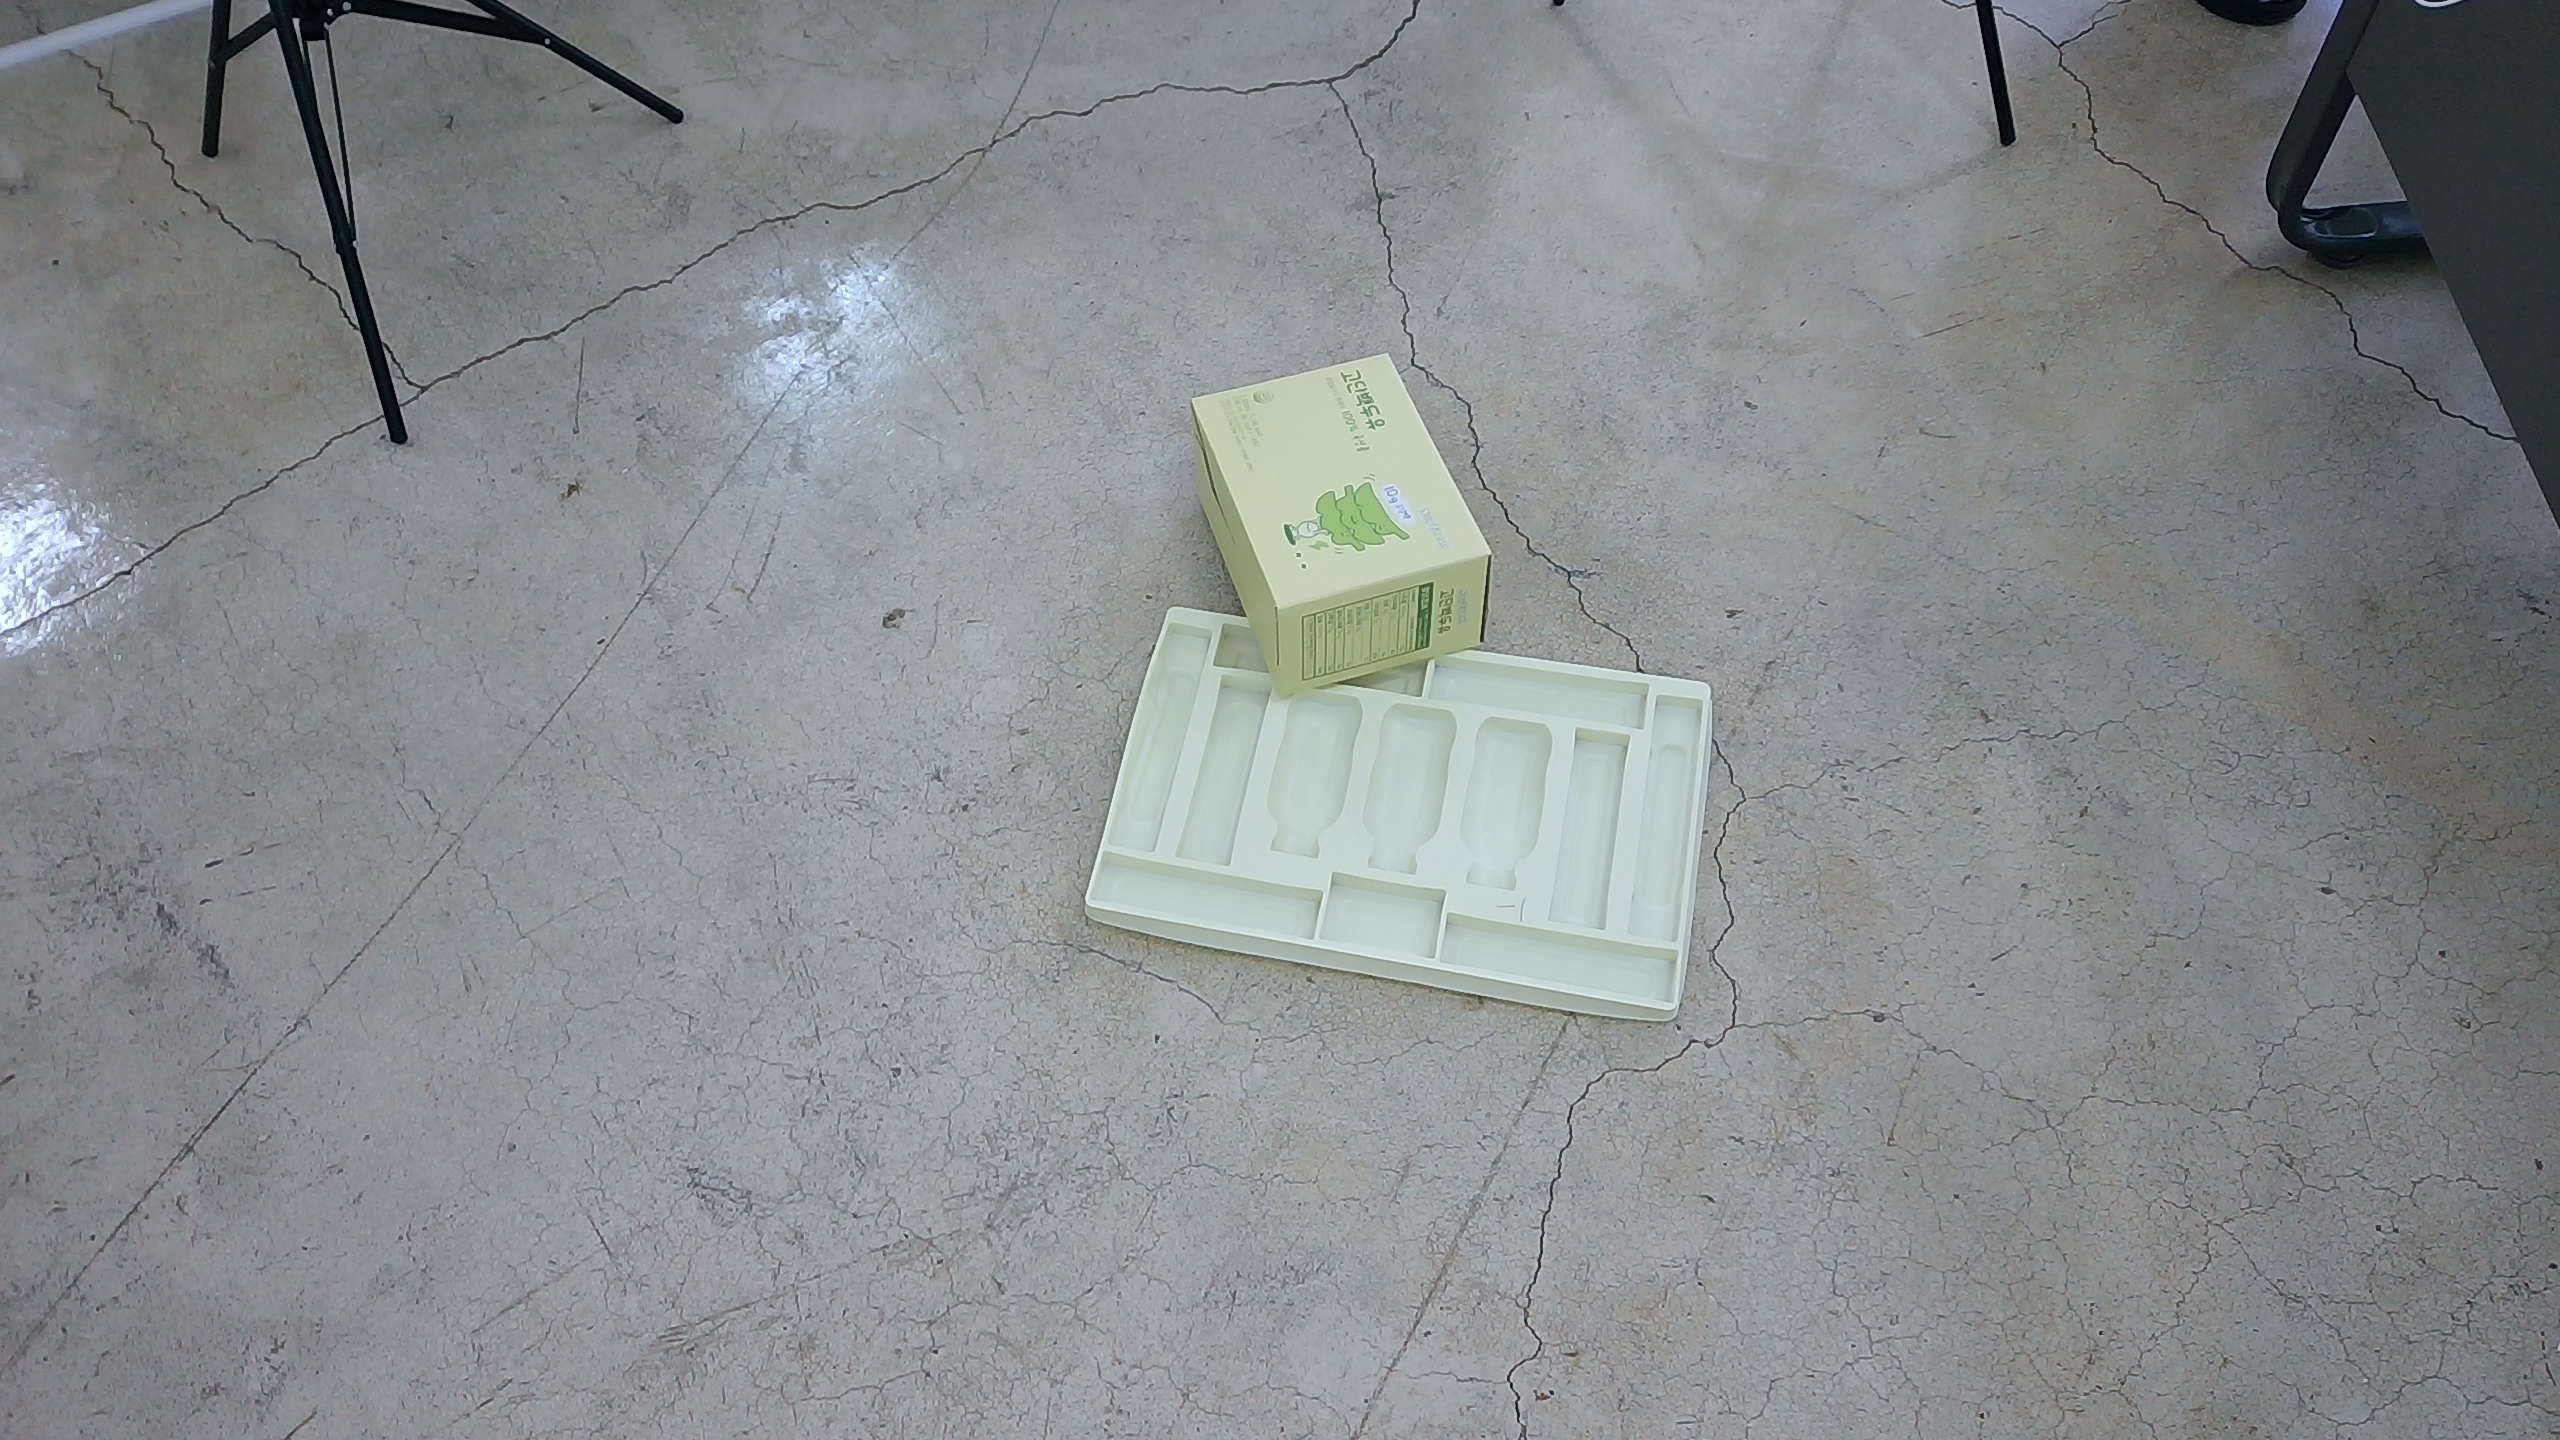

In [5]:
img

In [6]:
np.unique(mask)

array([ 0,  1, 11], dtype=uint8)

In [5]:
mask = Image.open('./data_Mask_RCNN/labels/train/' + train_labels[0])
mask = np.array(mask)
obj_ids = np.unique(mask)
obj_ids = obj_ids[1:]
num_objs = len(obj_ids)
masks = np.zeros((num_objs, mask.shape[0], mask.shape[1]))
masks

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [6]:
obj_ids

array([ 1, 11], dtype=uint8)

In [7]:
for idx, value in enumerate(obj_ids):
    masks[idx][mask == value] = value

In [8]:
np.unique(masks[0])

array([0., 1.])

In [9]:
np.unique(masks[1])

array([ 0., 11.])

In [10]:
masks

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [11]:
masks.shape

(2, 1440, 2560)

In [10]:
type(masks)

numpy.ndarray

In [6]:
labels = torch.tensor(obj_ids, dtype=torch.int64)
labels

tensor([12, 21, 23])

In [7]:
np.unique(masks[0])

array([ 0., 12.])

In [8]:
np.unique(masks[1])

array([ 0., 21.])

In [9]:
np.unique(masks[2])

array([ 0., 23.])

In [17]:
class WithweDataset(torch.utils.data.Dataset):
    def __init__(self, images, masks):
        self.imgs = images
        self.masks = masks
        
    def __getitem__(self, idx):
        img = Image.open('./data_Mask_RCNN/images/train/' + self.imgs[idx]).convert('RGB')
        mask = Image.open('./data_Mask_RCNN/labels/train/' + self.masks[idx])
        mask = np.array(mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)
        masks = np.zeros((num_objs, mask.shape[0], mask.shape[1]))
        for idx, value in enumerate(obj_ids):
            masks[idx][mask == value] = value
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype = torch.float32)
        labels = torch.tensor(obj_ids, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype = torch.uint8)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['masks'] = masks
        return T.ToTensor()(img), target
    
    def __len__(self):
        return len(self.imgs)

In [18]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn()
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 35)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, 35)

In [19]:
transform = T.ToTensor()

In [20]:
def custom_collate(data):
    return data

In [9]:
test_images = sorted(os.listdir('./data_Mask_RCNN/images/test'))
test_labels = sorted(os.listdir('./data_Mask_RCNN/labels/test'))

In [21]:
num = int(0.9 * len(train_images))
num = num if num % 2 == 0 else num + 1
train_imgs_inds = np.random.choice(range(len(train_images)), num, replace=False)
val_imgs_inds = np.setdiff1d(range(len(train_images)), train_imgs_inds)
train_imgs = np.array(train_images)[train_imgs_inds]
val_imgs = np.array(train_images)[val_imgs_inds]
train_masks = np.array(train_images)[train_imgs_inds]
val_masks = np.array(train_images)[val_imgs_inds]

In [22]:
train_dl = torch.utils.data.DataLoader(
    WithweDataset(train_imgs, train_masks),
    batch_size = 2,
    shuffle = True,
    collate_fn = custom_collate,
    num_workers = 0,
    pin_memory = True if torch.cuda.is_available() else False
)

val_dl = torch.utils.data.DataLoader(
    WithweDataset(val_imgs, val_masks),
    batch_size = 2,
    shuffle = True,
    collate_fn = custom_collate,
    num_workers = 0,
    pin_memory = True if torch.cuda.is_available() else False
)

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
#model.load_state_dict(torch.load('./Mask_RCNN_0829.pth'))

<All keys matched successfully>

In [24]:
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

In [25]:
params = [p for p in model.parameters() if p.requires_grad]

In [26]:
#optimizer = torch.optim.SGD(params, lr = 1e-5, momentum = 0.9, weight_decay = 0.0005)
optimizer = torch.optim.Adam(params, lr=1e-5)

In [15]:
what = next(iter(train_dl))

In [16]:
targ = [what[0][1], what[1][1]]
targets = [{k: v.to(device) for k, v in t.items()} for t in targ]

In [41]:
import torch.nn as nn

In [45]:
preds

[{'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>),
  'masks': tensor([], device='cuda:0', size=(0, 1, 1440, 2560))},
 {'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>),
  'masks': tensor([], device='cuda:0', size=(0, 1, 1440, 2560))}]

In [42]:
model.eval()
imgs = [what[0][0].to(device), what[1][0].to(device)]
loss = model(imgs, targets)

loss = nn.CrossEntropyLoss()(preds, label.long().to(device))
loss

TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not list

In [19]:
loss.values()

dict_values([tensor(3.6236, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.0981, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.1388, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), tensor(0.6854, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), tensor(0.0708, device='cuda:0', grad_fn=<DivBackward0>)])

In [22]:
losses = sum([l for l in loss.values()])
train_epoch_loss = losses.cpu().detach().numpy()
print(losses)
print(train_epoch_loss)

tensor(7.6167, device='cuda:0', grad_fn=<AddBackward0>)
7.616734


In [38]:
for i, dt in enumerate(train_dl):
    imgs = [dt[0][0].to(device), dt[1][0].to(device)]
    targ = [dt[0][1], dt[1][1]]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
    loss = model(imgs, targets)
    losses = sum([l for l in loss.values()])
    train_epoch_loss = losses.cpu().detach().numpy()
    if train_epoch_loss < 0:
        print(targets)
        break

[{'boxes': tensor([[ 779.,  769., 1127.,  959.],
        [1119.,  511., 1483.,  894.],
        [ 841.,  545., 1163.,  778.],
        [1164.,  505., 1355.,  623.],
        [ 988.,  834., 1211., 1100.]], device='cuda:0'), 'labels': tensor([ 7, 16, 20, 23, 29], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
 

In [25]:
np.isnan(train_epoch_loss)

False

In [24]:
model.eval()
model(imgs)

[{'boxes': tensor([[1.8525e+03, 8.1062e+00, 1.9373e+03, 4.9325e+01],
          [1.8902e+03, 7.9310e+00, 1.9756e+03, 5.0385e+01],
          [1.8956e+03, 0.0000e+00, 1.9566e+03, 3.2262e+01],
          [1.8787e+03, 3.6268e+01, 1.9669e+03, 7.8699e+01],
          [1.8881e+03, 2.1169e+01, 1.9474e+03, 8.8286e+01],
          [1.8753e+03, 2.3414e+01, 1.9614e+03, 6.5325e+01],
          [1.8503e+03, 0.0000e+00, 1.9361e+03, 2.7676e+01],
          [1.9110e+03, 1.3768e+01, 1.9705e+03, 7.9853e+01],
          [1.8439e+03, 3.7485e+01, 1.9297e+03, 7.9131e+01],
          [1.8682e+03, 4.7286e+01, 1.9540e+03, 8.7573e+01],
          [1.8435e+03, 0.0000e+00, 1.9441e+03, 8.6287e+01],
          [1.8764e+03, 0.0000e+00, 1.9813e+03, 1.3302e+02],
          [1.8358e+03, 0.0000e+00, 2.0107e+03, 5.1895e+01],
          [1.8525e+03, 1.5176e+01, 1.9105e+03, 7.9230e+01],
          [1.8977e+03, 4.5026e+01, 1.9570e+03, 1.0623e+02],
          [1.8455e+03, 0.0000e+00, 1.9048e+03, 4.6403e+01],
          [1.9063e+03, 0.0000e+

In [ ]:
target

In [28]:
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

In [29]:
test_img = Image.open('./data_Mask_RCNN/images/test/' + test_images[0]).convert('RGB')
transform = T.ToTensor()
ig = transform(test_img)
with torch.no_grad():
    pred = model([ig.to(device)])

In [30]:
pred

[{'boxes': tensor([], device='cuda:0', size=(0, 4)),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0'),
  'masks': tensor([], device='cuda:0', size=(0, 1, 1440, 2560))}]

In [ ]:
pred[0].boxes

In [15]:
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

tensor(0.)

In [ ]:
all_train_losses = []
all_val_losses = []
#flag = False

for epoch in range(50):
    train_epoch_loss = 0
    val_epoch_loss = 0
    model.train()
    for i, dt in enumerate(train_dl):
        imgs = [dt[0][0].to(device), dt[1][0].to(device)]
        targ = [dt[0][1], dt[1][1]]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
        loss = model(imgs, targets)
        
        #if not flag:
        #    for k, v in loss.items():
        #        print(f'{k}: {v}')
        #    flag = True
        for k, v in loss.items():
            print(f'{k}: {v}')
        
        losses = sum([l for l in loss.values()])
        train_epoch_loss += losses.cpu().detach().numpy()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    all_train_losses.append(train_epoch_loss)
    with torch.no_grad():
        for j, dt in enumerate(val_dl):
            imgs = [dt[0][0].to(device), dt[1][0].to(device)]
            targ = [dt[0][1], dt[1][1]]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
            loss = model(imgs, targets)
            losses = sum([l for l in loss.values()])
            val_epoch_loss += losses.cpu().detach().numpy()
        all_val_losses.append(val_epoch_loss)
    print(epoch, " ", train_epoch_loss, " ", val_epoch_loss)

loss_classifier: 3.5339102745056152
loss_box_reg: 0.05307578667998314
loss_mask: 4.293758392333984
loss_objectness: 0.6913238763809204
loss_rpn_box_reg: 0.0346992090344429
loss_classifier: 3.380774736404419
loss_box_reg: 0.10728172957897186
loss_mask: -1.8057860136032104
loss_objectness: 0.6895099878311157
loss_rpn_box_reg: 0.03530096635222435
loss_classifier: 3.2678682804107666
loss_box_reg: 0.10261891782283783
loss_mask: -4.266704082489014
loss_objectness: 0.6881803274154663
loss_rpn_box_reg: 0.0340571291744709
loss_classifier: 3.1287589073181152
loss_box_reg: 0.1504729986190796
loss_mask: -11.000530242919922
loss_objectness: 0.6866748929023743
loss_rpn_box_reg: 0.04413541406393051
loss_classifier: 3.0077481269836426
loss_box_reg: 0.18068118393421173
loss_mask: -1.9596078395843506
loss_objectness: 0.6840096712112427
loss_rpn_box_reg: 0.032195933163166046
loss_classifier: 2.9056856632232666
loss_box_reg: 0.2209494709968567
loss_mask: -17.135005950927734
loss_objectness: 0.681905269622

loss_classifier: 4.611737251281738
loss_box_reg: 2.0271244049072266
loss_mask: -4716.4658203125
loss_objectness: 0.36537104845046997
loss_rpn_box_reg: 0.33077675104141235
loss_classifier: 3.0566768646240234
loss_box_reg: 0.4955216646194458
loss_mask: -10870.775390625
loss_objectness: 0.402149498462677
loss_rpn_box_reg: 0.2420324683189392
loss_classifier: 1.4719715118408203
loss_box_reg: 0.6831538677215576
loss_mask: -27410.919921875
loss_objectness: 0.8325688242912292
loss_rpn_box_reg: 0.8599832057952881
loss_classifier: 5.204135894775391
loss_box_reg: 1.1184202432632446
loss_mask: -26815.224609375
loss_objectness: 1.0720921754837036
loss_rpn_box_reg: 0.9937894344329834
loss_classifier: 2.583218812942505
loss_box_reg: 0.8346455097198486
loss_mask: -30335.65625
loss_objectness: 0.32426583766937256
loss_rpn_box_reg: 0.5506101846694946
loss_classifier: 5.0569376945495605
loss_box_reg: 1.2707087993621826
loss_mask: -43785.9765625
loss_objectness: 1.1594772338867188
loss_rpn_box_reg: 1.1560

loss_classifier: 1452533.875
loss_box_reg: 2364208.25
loss_mask: -12763428864.0
loss_objectness: 20092.46484375
loss_rpn_box_reg: 42211.71484375
loss_classifier: 2439889.75
loss_box_reg: 3410805.0
loss_mask: -17977382912.0
loss_objectness: 22541.349609375
loss_rpn_box_reg: 65730.7421875
loss_classifier: 1698375.75
loss_box_reg: 3669310.5
loss_mask: -42148892672.0
loss_objectness: 9964.966796875
loss_rpn_box_reg: 86282.796875
loss_classifier: 2002726.625
loss_box_reg: 5014942.5
loss_mask: -49605890048.0
loss_objectness: 36394.50390625
loss_rpn_box_reg: 71675.703125
loss_classifier: 3258447.0
loss_box_reg: 6778159.5
loss_mask: -33867726848.0
loss_objectness: 30809.462890625
loss_rpn_box_reg: 88800.3203125
loss_classifier: 4950096.0
loss_box_reg: 7629253.0
loss_mask: -70864723968.0
loss_objectness: 17618.326171875
loss_rpn_box_reg: 104338.796875
loss_classifier: 4787147.0
loss_box_reg: 12582786.0
loss_mask: -8642496512.0
loss_objectness: 29808.326171875
loss_rpn_box_reg: 118216.59375
loss

loss_classifier: 426975002624.0
loss_box_reg: 1384039841792.0
loss_mask: -2.4626361504733594e+17
loss_objectness: 9682186240.0
loss_rpn_box_reg: 42248347648.0
loss_classifier: 617252847616.0
loss_box_reg: 1863953940480.0
loss_mask: -1.2275715752643789e+17
loss_objectness: 10913420288.0
loss_rpn_box_reg: 38397665280.0
loss_classifier: 680294547456.0
loss_box_reg: 2243313795072.0
loss_mask: -1.9884805227282432e+17
loss_objectness: 14525746176.0
loss_rpn_box_reg: 49077088256.0
loss_classifier: 678428606464.0
loss_box_reg: 3150515011584.0
loss_mask: -4.723988486820987e+17
loss_objectness: 20038295552.0
loss_rpn_box_reg: 118412640256.0
loss_classifier: 2041705922560.0
loss_box_reg: 3179438145536.0
loss_mask: -5.7134238823717274e+17
loss_objectness: 18922483712.0
loss_rpn_box_reg: 69130960896.0
loss_classifier: 2156891471872.0
loss_box_reg: 3527840628736.0
loss_mask: -7.772406465062502e+17
loss_objectness: 23392083968.0
loss_rpn_box_reg: 122328358912.0
loss_classifier: 3558618693632.0
loss_b

loss_classifier: 6239755868045312.0
loss_box_reg: 1.1923703239540736e+16
loss_mask: -1.7029629030062176e+22
loss_objectness: 62218326507520.0
loss_rpn_box_reg: 856208374235136.0
loss_classifier: 3015251725385728.0
loss_box_reg: 1.1743762363449344e+16
loss_mask: -1.3351052825628936e+22
loss_objectness: 62344684109824.0
loss_rpn_box_reg: 755322746568704.0
loss_classifier: 2386544212049920.0
loss_box_reg: 9055519784304640.0
loss_mask: -1.6704955525725782e+22
loss_objectness: 54460621520896.0
loss_rpn_box_reg: 379846907658240.0
loss_classifier: 5294879169052672.0
loss_box_reg: 7946913026408448.0
loss_mask: -1.806227627712056e+22
loss_objectness: 93173275688960.0
loss_rpn_box_reg: 366158175797248.0
loss_classifier: 5979851827707904.0
loss_box_reg: 1.32233453109248e+16
loss_mask: -1.483796803400102e+22
loss_objectness: 141987357392896.0
loss_rpn_box_reg: 1173046836592640.0
loss_classifier: 6233339186905088.0
loss_box_reg: 1.2720751459172352e+16
loss_mask: -1.4266660525571215e+22
loss_objectn

loss_classifier: 14446534590464.0
loss_box_reg: 10733969473536.0
loss_mask: -7.145861979108729e+22
loss_objectness: 1079759610052608.0
loss_rpn_box_reg: 1616160760004608.0
loss_classifier: 3.5609591007232666
loss_box_reg: 0.007347315549850464
loss_mask: -6.7981205871209805e+22
loss_objectness: 1139112568422400.0
loss_rpn_box_reg: 1213615084404736.0
loss_classifier: 22330795360256.0
loss_box_reg: 39771594293248.0
loss_mask: -5.960227677888551e+22
loss_objectness: 406254279196672.0
loss_rpn_box_reg: 737393674027008.0
loss_classifier: 3.5709919929504395
loss_box_reg: 0.006791623774915934
loss_mask: -5.515982252365582e+22
loss_objectness: 1188065531920384.0
loss_rpn_box_reg: 1037590882942976.0
loss_classifier: 3.5599000453948975
loss_box_reg: 0.006432720459997654
loss_mask: -6.412882674995708e+22
loss_objectness: 705114310443008.0
loss_rpn_box_reg: 718614734831616.0
loss_classifier: 1066603380736.0
loss_box_reg: 1198576631808.0
loss_mask: -6.291184154065089e+22
loss_objectness: 55737253573

loss_classifier: 3.5595061779022217
loss_box_reg: 0.004406522959470749
loss_mask: -4.9482066919435425e+22
loss_objectness: 51218122539008.0
loss_rpn_box_reg: 482057935388672.0
loss_classifier: 7230185799680.0
loss_box_reg: 54822875168768.0
loss_mask: -5.722408794525773e+22
loss_objectness: 71097470943232.0
loss_rpn_box_reg: 1603374642364416.0
loss_classifier: 3.561896562576294
loss_box_reg: 0.005103616043925285
loss_mask: -7.568726115040793e+22
loss_objectness: 97193885171712.0
loss_rpn_box_reg: 4521501587931136.0
loss_classifier: 3.5613999366760254
loss_box_reg: 0.00693537387996912
loss_mask: -7.0713625333528405e+22
loss_objectness: 241032407023616.0
loss_rpn_box_reg: 758798046199808.0
loss_classifier: 4663694327808.0
loss_box_reg: 3370515169280.0
loss_mask: -6.641425494205991e+22
loss_objectness: 281999331819520.0
loss_rpn_box_reg: 1464992943570944.0
loss_classifier: 3.5596725940704346
loss_box_reg: 0.008033418096601963
loss_mask: -9.285948652957163e+22
loss_objectness: 4370718775050

loss_classifier: 3.5607821941375732
loss_box_reg: 0.005182287190109491
loss_mask: -6.65490792041045e+22
loss_objectness: 395141521080320.0
loss_rpn_box_reg: 683863214915584.0
loss_classifier: 310710894592.0
loss_box_reg: 1311656116224.0
loss_mask: -5.2270389563928575e+22
loss_objectness: 894622628839424.0
loss_rpn_box_reg: 2059273609674752.0
loss_classifier: 3.55734920501709
loss_box_reg: 0.00506450142711401
loss_mask: -7.955259262418897e+22
loss_objectness: 750195360923648.0
loss_rpn_box_reg: 2148327072202752.0
loss_classifier: 8132308762624.0
loss_box_reg: 11496936439808.0
loss_mask: -6.338485010591399e+22
loss_objectness: 594825724297216.0
loss_rpn_box_reg: 3108144083369984.0
loss_classifier: 3.5564827919006348
loss_box_reg: 0.006010992918163538
loss_mask: -6.359800547627743e+22
loss_objectness: 410005564030976.0
loss_rpn_box_reg: 2840839545946112.0
loss_classifier: 3.557180166244507
loss_box_reg: 0.00616161385551095
loss_mask: -7.203067602295514e+22
loss_objectness: 434655622856704

loss_classifier: 3.5558128356933594
loss_box_reg: 0.006448902655392885
loss_mask: -8.973772637586723e+22
loss_objectness: 310044159639552.0
loss_rpn_box_reg: 1360648726380544.0
loss_classifier: 3.548837900161743
loss_box_reg: 0.0060884892009198666
loss_mask: -7.008498587594227e+22
loss_objectness: 143997871849472.0
loss_rpn_box_reg: 842119673544704.0
loss_classifier: 3.5545828342437744
loss_box_reg: 0.004676172975450754
loss_mask: -7.952485045048437e+22
loss_objectness: 78561713061888.0
loss_rpn_box_reg: 1445005507952640.0
loss_classifier: 3.554727792739868
loss_box_reg: 0.004771306645125151
loss_mask: -9.178048710924845e+22
loss_objectness: 365342199119872.0
loss_rpn_box_reg: 1605672718303232.0
loss_classifier: 3.5615718364715576
loss_box_reg: 0.006666700355708599
loss_mask: -8.22794051049715e+22
loss_objectness: 162664219148288.0
loss_rpn_box_reg: 1455373424787456.0
loss_classifier: 3.556445598602295
loss_box_reg: 0.005248899105936289
loss_mask: -9.23570199191459e+22
loss_objectness:

loss_classifier: 3.559988498687744
loss_box_reg: 0.004761905875056982
loss_mask: -7.349996639418551e+22
loss_objectness: 97767749844992.0
loss_rpn_box_reg: 1421096767193088.0
loss_classifier: 270809113296896.0
loss_box_reg: 311783755612160.0
loss_mask: -7.696045578666334e+22
loss_objectness: 485305333317632.0
loss_rpn_box_reg: 1634788704256000.0
loss_classifier: 3.5576775074005127
loss_box_reg: 0.007089934777468443
loss_mask: -7.52262411673529e+22
loss_objectness: 160892595470336.0
loss_rpn_box_reg: 1448818499387392.0
loss_classifier: 3.5625593662261963
loss_box_reg: 0.005937778856605291
loss_mask: -1.2267152363011262e+23
loss_objectness: 93545687941120.0
loss_rpn_box_reg: 2193565962731520.0
loss_classifier: 3.5635297298431396
loss_box_reg: 0.00510984193533659
loss_mask: -9.898493146195005e+22
loss_objectness: 175394250555392.0
loss_rpn_box_reg: 1544640025067520.0
loss_classifier: 3.2570667266845703
loss_box_reg: 9480674301968384.0
loss_mask: -5.358801221050799e+22
loss_objectness: 370

loss_classifier: 3.5491058826446533
loss_box_reg: 0.004560749977827072
loss_mask: -1.0925594885852226e+23
loss_objectness: 499120129179648.0
loss_rpn_box_reg: 1486086199050240.0
loss_classifier: 82074417496064.0
loss_box_reg: 119912232124416.0
loss_mask: -7.390937962911051e+22
loss_objectness: 255238934102016.0
loss_rpn_box_reg: 750063022243840.0
loss_classifier: 126902962487296.0
loss_box_reg: 2.3780263255343104e+16
loss_mask: -4.935533562592122e+22
loss_objectness: 265355930894336.0
loss_rpn_box_reg: 1180395794071552.0
loss_classifier: 3.5545883178710938
loss_box_reg: 0.008618307299911976
loss_mask: -8.28890663937279e+22
loss_objectness: 47060652916736.0
loss_rpn_box_reg: 1675421645012992.0
loss_classifier: 264026118422528.0
loss_box_reg: 199456687390720.0
loss_mask: -8.148604198741465e+22
loss_objectness: 341378395537408.0
loss_rpn_box_reg: 436426390896640.0
loss_classifier: 341084458713088.0
loss_box_reg: 650662580846592.0
loss_mask: -1.2398414277750603e+23
loss_objectness: 4621227

loss_classifier: 3.562554121017456
loss_box_reg: 0.0048638880252838135
loss_mask: -1.1483615199121418e+23
loss_objectness: 391027445727232.0
loss_rpn_box_reg: 502630459637760.0
loss_classifier: 3.557175874710083
loss_box_reg: 0.0040406594052910805
loss_mask: -1.016667619896544e+23
loss_objectness: 330017569505280.0
loss_rpn_box_reg: 1285723961425920.0
loss_classifier: 3.5545284748077393
loss_box_reg: 0.005723230075091124
loss_mask: -8.66620830823471e+22
loss_objectness: 238803302219776.0
loss_rpn_box_reg: 1612969867739136.0
loss_classifier: 3.5632388591766357
loss_box_reg: 0.00640231603756547
loss_mask: -7.796771286492251e+22
loss_objectness: 203445118173184.0
loss_rpn_box_reg: 1419454747508736.0
1   -2.2106481944111157e+25   -2.7503419648776855e+24
loss_classifier: 3.5495543479919434
loss_box_reg: 0.006595171056687832
loss_mask: -8.958213601594083e+22
loss_objectness: 254221010075648.0
loss_rpn_box_reg: 500489217114112.0
loss_classifier: 3.5576698780059814
loss_box_reg: 0.004188342019

loss_classifier: 74497709309952.0
loss_box_reg: 159427894181888.0
loss_mask: -9.156782713484401e+22
loss_objectness: 454242385002496.0
loss_rpn_box_reg: 1838688652754944.0
loss_classifier: 3.553532123565674
loss_box_reg: 0.005989918019622564
loss_mask: -7.669951722425349e+22
loss_objectness: 188174764605440.0
loss_rpn_box_reg: 1714228553580544.0
loss_classifier: 3.5550174713134766
loss_box_reg: 0.004722389858216047
loss_mask: -1.1383354262777045e+23
loss_objectness: 267439426240512.0
loss_rpn_box_reg: 2037917421666304.0
loss_classifier: 3.560199499130249
loss_box_reg: 0.006051189266145229
loss_mask: -8.804866034282118e+22
loss_objectness: 472433316331520.0
loss_rpn_box_reg: 907032131534848.0
loss_classifier: 3.563258171081543
loss_box_reg: 0.0071388366632163525
loss_mask: -1.039277851753765e+23
loss_objectness: 359247170764800.0
loss_rpn_box_reg: 787308844417024.0
loss_classifier: 3.556058645248413
loss_box_reg: 0.0064926170744001865
loss_mask: -1.1054248315687393e+23
loss_objectness: 

loss_classifier: 3.5518319606781006
loss_box_reg: 0.006026138551533222
loss_mask: -9.467286992673162e+22
loss_objectness: 448704695762944.0
loss_rpn_box_reg: 1788898975940608.0
loss_classifier: 3.5498034954071045
loss_box_reg: 0.005931175779551268
loss_mask: -6.2058472461658965e+22
loss_objectness: 362009304498176.0
loss_rpn_box_reg: 1975836353757184.0
loss_classifier: 3.5522422790527344
loss_box_reg: 0.0061692604795098305
loss_mask: -1.1149536377323224e+23
loss_objectness: 449172109000704.0
loss_rpn_box_reg: 98615066361856.0
loss_classifier: 3.556866407394409
loss_box_reg: 0.005691081285476685
loss_mask: -1.0900640440316966e+23
loss_objectness: 369419263934464.0
loss_rpn_box_reg: 1798637277413376.0
loss_classifier: 3.5472750663757324
loss_box_reg: 0.004202410578727722
loss_mask: -1.0170174595155981e+23
loss_objectness: 542951579058176.0
loss_rpn_box_reg: 1168563427606528.0
loss_classifier: 2234656489472.0
loss_box_reg: 2720627425280.0
loss_mask: -1.2333573251755573e+23
loss_objectness

loss_classifier: 3.55410099029541
loss_box_reg: 0.005068726371973753
loss_mask: -1.043354870424431e+23
loss_objectness: 389934443659264.0
loss_rpn_box_reg: 2039155848642560.0
loss_classifier: 3.558295249938965
loss_box_reg: 0.004279987886548042
loss_mask: -1.171465886720478e+23
loss_objectness: 296859784445952.0
loss_rpn_box_reg: 2183672237129728.0
loss_classifier: 3.5558559894561768
loss_box_reg: 0.004406233783811331
loss_mask: -1.0300745657712483e+23
loss_objectness: 163700648443904.0
loss_rpn_box_reg: 2467522599190528.0
loss_classifier: 9328323985408.0
loss_box_reg: 19300777721856.0
loss_mask: -1.1297074301115881e+23
loss_objectness: 217955195420672.0
loss_rpn_box_reg: 1405456643784704.0
loss_classifier: 3.553635358810425
loss_box_reg: 0.003871065331622958
loss_mask: -7.473950112682595e+22
loss_objectness: 295457712504832.0
loss_rpn_box_reg: 1920790442278912.0
loss_classifier: 3.5527689456939697
loss_box_reg: 0.0053434609435498714
loss_mask: -1.042542691267631e+23
loss_objectness: 3

loss_classifier: 1152654734524416.0
loss_box_reg: 1658953129787392.0
loss_mask: -1.3174141299166661e+23
loss_objectness: 1036934960906240.0
loss_rpn_box_reg: 4784326206029824.0
loss_classifier: 3.554455041885376
loss_box_reg: 0.005485869478434324
loss_mask: -1.049381227157808e+23
loss_objectness: 247680630521856.0
loss_rpn_box_reg: 9737030162448384.0
loss_classifier: 3.5491220951080322
loss_box_reg: 0.00537670636549592
loss_mask: -6.610421363291284e+22
loss_objectness: 313851010613248.0
loss_rpn_box_reg: 1479231431245824.0
loss_classifier: 3.5597658157348633
loss_box_reg: 0.0059791142120957375
loss_mask: -8.969348301312794e+22
loss_objectness: 91514160021504.0
loss_rpn_box_reg: 2485541866045440.0
loss_classifier: 2514361778176.0
loss_box_reg: 2494365433856.0
loss_mask: -1.2967502637464021e+23
loss_objectness: 249658832060416.0
loss_rpn_box_reg: 1565567387435008.0
loss_classifier: 3.5456786155700684
loss_box_reg: 0.005162387154996395
loss_mask: -1.0297098642734238e+23
loss_objectness: 1

loss_classifier: 3.5540380477905273
loss_box_reg: 0.005036722868680954
loss_mask: -1.2933831024490023e+23
loss_objectness: 2205571470065664.0
loss_rpn_box_reg: 6271087117598720.0
loss_classifier: 3.554579257965088
loss_box_reg: 0.006300066597759724
loss_mask: -1.2088040602951036e+23
loss_objectness: 96416160546816.0
loss_rpn_box_reg: 1685176857919488.0
loss_classifier: 3.553088903427124
loss_box_reg: 0.0055164010263979435
loss_mask: -8.850594684178512e+22
loss_objectness: 634726238912512.0
loss_rpn_box_reg: 2039788953665536.0
loss_classifier: 3.5597269535064697
loss_box_reg: 0.005185290239751339
loss_mask: -1.2619296023634765e+23
loss_objectness: 594537760161792.0
loss_rpn_box_reg: 6923089996677120.0
loss_classifier: 3.5592398643493652
loss_box_reg: 0.00521840900182724
loss_mask: -5.950305797549491e+22
loss_objectness: 292065292320768.0
loss_rpn_box_reg: 2894540058918912.0
loss_classifier: 3.5536699295043945
loss_box_reg: 0.0037390945944935083
loss_mask: -1.1241523300432192e+23
loss_ob

loss_classifier: 3.558319330215454
loss_box_reg: 0.0050369747914373875
loss_mask: -1.5075024232766902e+23
loss_objectness: 468869969870848.0
loss_rpn_box_reg: 1795490140127232.0
loss_classifier: 3.554157257080078
loss_box_reg: 0.006335569079965353
loss_mask: -9.83357555900631e+22
loss_objectness: 378769944608768.0
loss_rpn_box_reg: 1983266915614720.0
loss_classifier: 3.5503203868865967
loss_box_reg: 0.004360381048172712
loss_mask: -9.60332362373744e+22
loss_objectness: 377985878196224.0
loss_rpn_box_reg: 991575475748864.0
loss_classifier: 17337671483392.0
loss_box_reg: 51364021403648.0
loss_mask: -1.5321835003145687e+23
loss_objectness: 531581559111680.0
loss_rpn_box_reg: 1809013918400512.0
loss_classifier: 3.5528435707092285
loss_box_reg: 0.003891387488692999
loss_mask: -9.160862074026873e+22
loss_objectness: 409719680270336.0
loss_rpn_box_reg: 1406490657161216.0
loss_classifier: 3.550959348678589
loss_box_reg: 0.00509756151586771
loss_mask: -1.0570106852145438e+23
loss_objectness: 32

loss_classifier: 56095401836544.0
loss_box_reg: 76360575877120.0
loss_mask: -1.0472473315823673e+23
loss_objectness: 498777504874496.0
loss_rpn_box_reg: 847404563693568.0
loss_classifier: 3.554046630859375
loss_box_reg: 0.004450214561074972
loss_mask: -8.69642656101444e+22
loss_objectness: 100424715599872.0
loss_rpn_box_reg: 510535783153664.0
loss_classifier: 28057779830784.0
loss_box_reg: 19595551309824.0
loss_mask: -1.3701143520362302e+23
loss_objectness: 2215200249872384.0
loss_rpn_box_reg: 1843617933033472.0
loss_classifier: 3.554041862487793
loss_box_reg: 0.004915050230920315
loss_mask: -1.0927153131323296e+23
loss_objectness: 80683150082048.0
loss_rpn_box_reg: 545784009326592.0
loss_classifier: 3.555321216583252
loss_box_reg: 0.005767489317804575
loss_mask: -1.162720166460102e+23
loss_objectness: 352873976168448.0
loss_rpn_box_reg: 2590435973267456.0
loss_classifier: 3.5435292720794678
loss_box_reg: 0.0040596770122647285
loss_mask: -9.124750410774766e+22
loss_objectness: 25330007

loss_classifier: 3.545409679412842
loss_box_reg: 0.0033633182756602764
loss_mask: -1.4023684119915173e+23
loss_objectness: 763645856317440.0
loss_rpn_box_reg: 4250143943557120.0
loss_classifier: 3.234419345855713
loss_box_reg: 1101839728640.0
loss_mask: -1.140529670088152e+23
loss_objectness: 223713203060736.0
loss_rpn_box_reg: 2095422201921536.0
loss_classifier: 3.542848825454712
loss_box_reg: 0.003479802282527089
loss_mask: -1.5793415927326907e+23
loss_objectness: 594573730512896.0
loss_rpn_box_reg: 1856241647222784.0
loss_classifier: 3.560497760772705
loss_box_reg: 0.0047080968506634235
loss_mask: -8.947812988614634e+22
loss_objectness: 1071463276740608.0
loss_rpn_box_reg: 6044872800731136.0
loss_classifier: 3.5514211654663086
loss_box_reg: 0.004664355423301458
loss_mask: -1.194235726148493e+23
loss_objectness: 403765714747392.0
loss_rpn_box_reg: 1854151742980096.0
loss_classifier: 3.559096097946167
loss_box_reg: 0.004649139009416103
loss_mask: -1.5641513114775402e+23
loss_objectnes

loss_classifier: 9596946087936.0
loss_box_reg: 13762680586240.0
loss_mask: -1.4802036739913989e+23
loss_objectness: 353663075745792.0
loss_rpn_box_reg: 884865469775872.0
loss_classifier: 3.3307645320892334
loss_box_reg: 2.0801316888510464e+16
loss_mask: -1.604650381486632e+23
loss_objectness: 332700648996864.0
loss_rpn_box_reg: 3971338020585472.0
loss_classifier: 121075883048960.0
loss_box_reg: 149250281308160.0
loss_mask: -1.4241840287304851e+23
loss_objectness: 2454535423393792.0
loss_rpn_box_reg: 5316638547116032.0
loss_classifier: 3.5494542121887207
loss_box_reg: 0.004786127712577581
loss_mask: -1.5103301434107236e+23
loss_objectness: 200093265297408.0
loss_rpn_box_reg: 1706831009284096.0
loss_classifier: 3.555971622467041
loss_box_reg: 0.003581153228878975
loss_mask: -1.069710746091736e+23
loss_objectness: 155043638542336.0
loss_rpn_box_reg: 1109334687744000.0
loss_classifier: 3.5450961589813232
loss_box_reg: 0.005716990679502487
loss_mask: -3.440152037280544e+22
loss_objectness: 

loss_classifier: 277699918561280.0
loss_box_reg: 165371675934720.0
loss_mask: -8.909989957504125e+22
loss_objectness: 206201564430336.0
loss_rpn_box_reg: 1720815825453056.0
loss_classifier: 7612209983127552.0
loss_box_reg: 8836759920050176.0
loss_mask: -5.060218870795613e+22
loss_objectness: 145500338651136.0
loss_rpn_box_reg: 1323767976427520.0
loss_classifier: 3.554882764816284
loss_box_reg: 0.0040526678785681725
loss_mask: -1.3733526203122947e+23
loss_objectness: 413323090722816.0
loss_rpn_box_reg: 3635302195265536.0
loss_classifier: 3.55631947517395
loss_box_reg: 0.0046773343347013
loss_mask: -9.813196770692459e+22
loss_objectness: 36172407504896.0
loss_rpn_box_reg: 3263689545220096.0
loss_classifier: 3.5447027683258057
loss_box_reg: 0.00381280155852437
loss_mask: -1.1448550172422711e+23
loss_objectness: 193214405410816.0
loss_rpn_box_reg: 1389946443137024.0
loss_classifier: 3.551687479019165
loss_box_reg: 0.0033800017554312944
loss_mask: -1.911756244396579e+23
loss_objectness: 284

loss_classifier: 3.5567948818206787
loss_box_reg: 0.003956757020205259
loss_mask: -8.08565108171023e+22
loss_objectness: 234271910395904.0
loss_rpn_box_reg: 532984805457920.0
loss_classifier: 3.5518691539764404
loss_box_reg: 0.004716464318335056
loss_mask: -1.4935856699241676e+23
loss_objectness: 587307182718976.0
loss_rpn_box_reg: 2864425895723008.0
loss_classifier: 3.227494955062866
loss_box_reg: 2.0844038928203776e+16
loss_mask: -1.381188343231964e+23
loss_objectness: 414730665590784.0
loss_rpn_box_reg: 6037257286844416.0
loss_classifier: 3.5521798133850098
loss_box_reg: 0.00434267008677125
loss_mask: -1.4183909584578059e+23
loss_objectness: 629774611382272.0
loss_rpn_box_reg: 4040394920689664.0
loss_classifier: 3.550863742828369
loss_box_reg: 0.004251967649906874
loss_mask: -1.1956442719679494e+23
loss_objectness: 567536710057984.0
loss_rpn_box_reg: 3571602729992192.0
loss_classifier: 3.5523643493652344
loss_box_reg: 0.0035152530763298273
loss_mask: -5.815364441914589e+22
loss_obje

loss_classifier: 3.545992136001587
loss_box_reg: 0.0036629359237849712
loss_mask: -1.1740952683269219e+23
loss_objectness: 272270190706688.0
loss_rpn_box_reg: 5429141994209280.0
loss_classifier: 3.5463621616363525
loss_box_reg: 0.004997159820050001
loss_mask: -1.3899747760329714e+23
loss_objectness: 245228355190784.0
loss_rpn_box_reg: 5126753747992576.0
loss_classifier: 3.554330587387085
loss_box_reg: 0.00537688285112381
loss_mask: -1.5290659285085178e+23
loss_objectness: 477667472179200.0
loss_rpn_box_reg: 6034579374735360.0
loss_classifier: 3.5471813678741455
loss_box_reg: 0.00391812901943922
loss_mask: -1.267627106252063e+23
loss_objectness: 227891333824512.0
loss_rpn_box_reg: 1020076476071936.0
loss_classifier: 3.551464080810547
loss_box_reg: 0.005091147497296333
loss_mask: -9.066164884662154e+22
loss_objectness: 305954713239552.0
loss_rpn_box_reg: 2792019189563392.0
loss_classifier: 3.5543911457061768
loss_box_reg: 0.003754952922463417
loss_mask: -1.3917680193325977e+23
loss_objec

loss_classifier: 3.552155017852783
loss_box_reg: 0.0038634894881397486
loss_mask: -1.549261690533513e+23
loss_objectness: 621199574958080.0
loss_rpn_box_reg: 2318423883251712.0
loss_classifier: 3.546044111251831
loss_box_reg: 0.003516225377097726
loss_mask: -1.1416896172081775e+23
loss_objectness: 317636252532736.0
loss_rpn_box_reg: 2295881478963200.0
loss_classifier: 3.542839765548706
loss_box_reg: 0.003799709491431713
loss_mask: -1.5541736765750934e+23
loss_objectness: 617920635863040.0
loss_rpn_box_reg: 3657620187512832.0
loss_classifier: 3.555511474609375
loss_box_reg: 0.004551219753921032
loss_mask: -1.6207366989236442e+23
loss_objectness: 302023543095296.0
loss_rpn_box_reg: 2099589528158208.0
loss_classifier: 3.550758123397827
loss_box_reg: 0.003758314996957779
loss_mask: -1.4639671164708177e+23
loss_objectness: 1225119825395712.0
loss_rpn_box_reg: 2493076043988992.0
loss_classifier: 3.5450308322906494
loss_box_reg: 0.004391303285956383
loss_mask: -1.514163697485534e+23
loss_obje

loss_classifier: 3.548832893371582
loss_box_reg: 0.0037781528662890196
loss_mask: -1.5420492658022716e+23
loss_objectness: 225525494710272.0
loss_rpn_box_reg: 1698373547589632.0
loss_classifier: 3.544053316116333
loss_box_reg: 0.004172955173999071
loss_mask: -1.3583269005875283e+23
loss_objectness: 473276270772224.0
loss_rpn_box_reg: 888339762774016.0
loss_classifier: 3.5512609481811523
loss_box_reg: 0.004972882103174925
loss_mask: -1.5202107707771968e+23
loss_objectness: 373670744686592.0
loss_rpn_box_reg: 2005762075262976.0
loss_classifier: 3.5442943572998047
loss_box_reg: 0.004504302050918341
loss_mask: -1.109090941809404e+23
loss_objectness: 241288980987904.0
loss_rpn_box_reg: 6258949540020224.0
loss_classifier: 3.5423758029937744
loss_box_reg: 0.0045378971844911575
loss_mask: -1.4823539626694832e+23
loss_objectness: 95420726378496.0
loss_rpn_box_reg: 3942571940249600.0
loss_classifier: 15783480524800.0
loss_box_reg: 44104083832832.0
loss_mask: -1.615800573588061e+23
loss_objectnes

loss_classifier: 3.5505480766296387
loss_box_reg: 0.00441636610776186
loss_mask: -1.4573323234277829e+23
loss_objectness: 100166002540544.0
loss_rpn_box_reg: 1865066194403328.0
loss_classifier: 18726808190976.0
loss_box_reg: 24617179676672.0
loss_mask: -1.4293035406428948e+23
loss_objectness: 222586965327872.0
loss_rpn_box_reg: 2088446906597376.0
loss_classifier: 3.541775941848755
loss_box_reg: 0.005675977095961571
loss_mask: -2.096955475037126e+22
loss_objectness: 178009583648768.0
loss_rpn_box_reg: 1034834856116224.0
loss_classifier: 16456406269952.0
loss_box_reg: 20518038142976.0
loss_mask: -9.203557999934197e+22
loss_objectness: 645665050853376.0
loss_rpn_box_reg: 3204087478747136.0
loss_classifier: 3.541736602783203
loss_box_reg: 0.0034103314392268658
loss_mask: -1.1955875266126445e+23
loss_objectness: 342574107721728.0
loss_rpn_box_reg: 2017595918123008.0
loss_classifier: 5878553950289920.0
loss_box_reg: 1.711823103459328e+16
loss_mask: -1.0510321567092094e+23
loss_objectness: 33

loss_classifier: 3.5530967712402344
loss_box_reg: 0.0037541911005973816
loss_mask: -1.6818633360900036e+23
loss_objectness: 434449967742976.0
loss_rpn_box_reg: 3449716658405376.0
loss_classifier: 3.5444531440734863
loss_box_reg: 0.0036225998774170876
loss_mask: -1.3743028798336699e+23
loss_objectness: 255592362934272.0
loss_rpn_box_reg: 705785399083008.0
loss_classifier: 3.5505402088165283
loss_box_reg: 0.005164481699466705
loss_mask: -1.6404875053054552e+23
loss_objectness: 447407179431936.0
loss_rpn_box_reg: 3908174889353216.0
loss_classifier: 3.5450403690338135
loss_box_reg: 0.0025752608198672533
loss_mask: -1.4663016023736614e+23
loss_objectness: 456362622451712.0
loss_rpn_box_reg: 3395854010417152.0
loss_classifier: 3.5471291542053223
loss_box_reg: 0.0044388133101165295
loss_mask: -7.657283096673556e+22
loss_objectness: 284098094432256.0
loss_rpn_box_reg: 6974813214081024.0
loss_classifier: 2044294508576768.0
loss_box_reg: 1.3840374271311872e+16
loss_mask: -1.2489104164166888e+23


loss_classifier: 51806897963008.0
loss_box_reg: 30542498103296.0
loss_mask: -1.8309007784145903e+23
loss_objectness: 253690782941184.0
loss_rpn_box_reg: 2248211905380352.0
loss_classifier: 1308069736742912.0
loss_box_reg: 2368861026385920.0
loss_mask: -6.178312238044153e+22
loss_objectness: 468263574175744.0
loss_rpn_box_reg: 3120389035130880.0
loss_classifier: 3.5469706058502197
loss_box_reg: 0.004106489010155201
loss_mask: -1.8450741468738806e+23
loss_objectness: 298516400308224.0
loss_rpn_box_reg: 3731504093986816.0
loss_classifier: 3.559039354324341
loss_box_reg: 0.005602702964097261
loss_mask: -1.4699316838173071e+23
loss_objectness: 265161919168512.0
loss_rpn_box_reg: 3446041777012736.0
loss_classifier: 3.2516517639160156
loss_box_reg: 1.2384057161678848e+16
loss_mask: -1.1876975803534616e+23
loss_objectness: 210961394827264.0
loss_rpn_box_reg: 1963297062518784.0
loss_classifier: 3.5457141399383545
loss_box_reg: 0.003448005300015211
loss_mask: -1.7607301926205306e+23
loss_objectn

loss_classifier: 3.544877052307129
loss_box_reg: 0.005568388383835554
loss_mask: -1.4696567840960524e+23
loss_objectness: 808036759240704.0
loss_rpn_box_reg: 3709876249296896.0
loss_classifier: 3.5533156394958496
loss_box_reg: 0.0028625172562897205
loss_mask: -1.726442126929538e+23
loss_objectness: 355062295560192.0
loss_rpn_box_reg: 976227745660928.0
loss_classifier: 3.544769287109375
loss_box_reg: 0.0041076927445828915
loss_mask: -1.1670464143341467e+23
loss_objectness: 754232965726208.0
loss_rpn_box_reg: 4913390510145536.0
loss_classifier: 3.5522966384887695
loss_box_reg: 0.003976982086896896
loss_mask: -1.5375215268808984e+23
loss_objectness: 1130126020444160.0
loss_rpn_box_reg: 5293578330832896.0
loss_classifier: 3.3081448078155518
loss_box_reg: 21081255575552.0
loss_mask: -1.4123395617105007e+23
loss_objectness: 602301114875904.0
loss_rpn_box_reg: 6770749654171648.0
loss_classifier: 3.5530788898468018
loss_box_reg: 0.00394815718755126
loss_mask: -7.990031555141825e+22
loss_object

loss_classifier: 3.539599657058716
loss_box_reg: 0.003302298951894045
loss_mask: -1.4467032878752332e+23
loss_objectness: 663012155326464.0
loss_rpn_box_reg: 1985813562785792.0
loss_classifier: 3.2943918704986572
loss_box_reg: 1.1396560428466176e+16
loss_mask: -1.3178791716141884e+23
loss_objectness: 807717321048064.0
loss_rpn_box_reg: 6252716468731904.0
loss_classifier: 3.553577184677124
loss_box_reg: 0.003520946018397808
loss_mask: -1.7622102556020697e+23
loss_objectness: 1017313335705600.0
loss_rpn_box_reg: 3316448655048704.0
loss_classifier: 3.5454578399658203
loss_box_reg: 0.003255169838666916
loss_mask: -1.572533050816032e+23
loss_objectness: 1856728052269056.0
loss_rpn_box_reg: 6567076936286208.0
loss_classifier: 3.553304672241211
loss_box_reg: 0.0023651840165257454
loss_mask: -2.1872916937746738e+23
loss_objectness: 1075824010723328.0
loss_rpn_box_reg: 4574887494549504.0
loss_classifier: 3.5406270027160645
loss_box_reg: 0.0038214700762182474
loss_mask: -8.904510878197466e+22
lo

loss_classifier: 3.547217607498169
loss_box_reg: 0.002878547180444002
loss_mask: -1.3770486344544851e+23
loss_objectness: 366416612032512.0
loss_rpn_box_reg: 6887312919101440.0
loss_classifier: 3.5449485778808594
loss_box_reg: 0.003971441648900509
loss_mask: -1.8193764272561194e+23
loss_objectness: 561696594722816.0
loss_rpn_box_reg: 3891837639065600.0
loss_classifier: 3.546400785446167
loss_box_reg: 0.003726699622347951
loss_mask: -1.5530960552562562e+23
loss_objectness: 554253651279872.0
loss_rpn_box_reg: 7619882942201856.0
loss_classifier: 3.547541379928589
loss_box_reg: 0.0042810686863958836
loss_mask: -1.670030037997095e+23
loss_objectness: 310590593564672.0
loss_rpn_box_reg: 6121482132389888.0
loss_classifier: 3.5466465950012207
loss_box_reg: 0.004154486116021872
loss_mask: -1.3580374992754735e+23
loss_objectness: 760373896544256.0
loss_rpn_box_reg: 1.294561661943808e+16
loss_classifier: 3.542062759399414
loss_box_reg: 0.0039011489134281874
loss_mask: -1.2324082365900853e+23
loss

loss_classifier: 3.5410306453704834
loss_box_reg: 0.0032980386167764664
loss_mask: -9.986515100192036e+22
loss_objectness: 420493102415872.0
loss_rpn_box_reg: 3254673603559424.0
loss_classifier: 3.5408952236175537
loss_box_reg: 0.003342016600072384
loss_mask: -7.004177383751765e+22
loss_objectness: 479642955808768.0
loss_rpn_box_reg: 3657444899160064.0
loss_classifier: 3.5476951599121094
loss_box_reg: 0.00279113813303411
loss_mask: -8.990294543179694e+22
loss_objectness: 202820837965824.0
loss_rpn_box_reg: 915243169480704.0
loss_classifier: 3.550140857696533
loss_box_reg: 0.0036095979157835245
loss_mask: -1.3634644268984475e+23
loss_objectness: 111470356463616.0
loss_rpn_box_reg: 5136670290608128.0
loss_classifier: 3.5425453186035156
loss_box_reg: 0.0028262741398066282
loss_mask: -1.701297629490003e+23
loss_objectness: 162034570231808.0
loss_rpn_box_reg: 3283044815339520.0
loss_classifier: 3.548661231994629
loss_box_reg: 0.0031407042406499386
loss_mask: -1.2683023759801909e+23
loss_obj

loss_classifier: 3.538278818130493
loss_box_reg: 0.0028980164788663387
loss_mask: -1.5092975580881601e+23
loss_objectness: 439333546885120.0
loss_rpn_box_reg: 1760602926088192.0
loss_classifier: 3.544217824935913
loss_box_reg: 0.003361885203048587
loss_mask: -1.5082273226727118e+23
loss_objectness: 512156495773696.0
loss_rpn_box_reg: 3560761427230720.0
loss_classifier: 3.5383028984069824
loss_box_reg: 0.0035547935403883457
loss_mask: -1.8156971665045428e+23
loss_objectness: 171454339481600.0
loss_rpn_box_reg: 2914612051705856.0
loss_classifier: 3.539330005645752
loss_box_reg: 0.003833650378510356
loss_mask: -1.3236491834567755e+23
loss_objectness: 737642715021312.0
loss_rpn_box_reg: 3586728799502336.0
loss_classifier: 1.999139987311821e+16
loss_box_reg: 1.4473176499093504e+16
loss_mask: -1.951008718028815e+23
loss_objectness: 944989374775296.0
loss_rpn_box_reg: 2038784333971456.0
loss_classifier: 3.5414819717407227
loss_box_reg: 0.00401105172932148
loss_mask: -1.4126393213016985e+23
lo

loss_classifier: 3.5392799377441406
loss_box_reg: 0.003713063895702362
loss_mask: -1.602091256034375e+23
loss_objectness: 463624338407424.0
loss_rpn_box_reg: 1850956824182784.0
loss_classifier: 3.5467841625213623
loss_box_reg: 0.0039056348614394665
loss_mask: -5.145248633200219e+22
loss_objectness: 204849790582784.0
loss_rpn_box_reg: 833684156448768.0
loss_classifier: 3988817732173824.0
loss_box_reg: 5.598577058172109e+16
loss_mask: -6.318450747649041e+22
loss_objectness: 90577144119296.0
loss_rpn_box_reg: 714052540039168.0
loss_classifier: 3.5365216732025146
loss_box_reg: 0.0030989970546215773
loss_mask: -1.3015887510420639e+23
loss_objectness: 146063851782144.0
loss_rpn_box_reg: 1267019915722752.0
loss_classifier: 2651761932238848.0
loss_box_reg: 1.5432836475518976e+16
loss_mask: -1.4079577394170543e+23
loss_objectness: 73033821716480.0
loss_rpn_box_reg: 1772838214172672.0
5   -3.7818545867553084e+25   -4.14039151417527e+24
loss_classifier: 3.549976348876953
loss_box_reg: 0.003803413

loss_classifier: 3.5380911827087402
loss_box_reg: 0.002744833007454872
loss_mask: -1.3246615926530084e+23
loss_objectness: 1533176623136768.0
loss_rpn_box_reg: 7788970972807168.0
loss_classifier: 3.5452449321746826
loss_box_reg: 0.00531891779974103
loss_mask: -1.541365979666807e+23
loss_objectness: 1824031271550976.0
loss_rpn_box_reg: 1608238424391680.0
loss_classifier: 3.5417275428771973
loss_box_reg: 0.0018504469189792871
loss_mask: -1.086630950035752e+23
loss_objectness: 933463628709888.0
loss_rpn_box_reg: 2574041546227712.0
loss_classifier: 3.545297384262085
loss_box_reg: 0.002929635113105178
loss_mask: -1.831390409766078e+23
loss_objectness: 1429049704448000.0
loss_rpn_box_reg: 4946611008438272.0
loss_classifier: 3.5412893295288086
loss_box_reg: 0.003814484691247344
loss_mask: -1.534676693068281e+23
loss_objectness: 1204978844696576.0
loss_rpn_box_reg: 6365248906854400.0
loss_classifier: 5857229144064.0
loss_box_reg: 6396269559808.0
loss_mask: -1.7241353832003987e+23
loss_objectne

loss_classifier: 3.5350043773651123
loss_box_reg: 0.0027871616184711456
loss_mask: -8.560181863647377e+22
loss_objectness: 463868212019200.0
loss_rpn_box_reg: 2858554406993920.0
loss_classifier: 3.5376439094543457
loss_box_reg: 0.0033084352035075426
loss_mask: -1.7415115315706898e+23
loss_objectness: 774855989395456.0
loss_rpn_box_reg: 3485497494077440.0
loss_classifier: 3.5401127338409424
loss_box_reg: 0.0030236090533435345
loss_mask: -1.3153126602585425e+23
loss_objectness: 358848208568320.0
loss_rpn_box_reg: 4521623457628160.0
loss_classifier: 3.540118932723999
loss_box_reg: 0.003277649637311697
loss_mask: -1.7321240483634136e+23
loss_objectness: 527132442755072.0
loss_rpn_box_reg: 9586622555226112.0
loss_classifier: 3.5406713485717773
loss_box_reg: 0.0030554919503629208
loss_mask: -2.0877363814199173e+23
loss_objectness: 984495020834816.0
loss_rpn_box_reg: 2325496083775488.0
loss_classifier: 3.541660785675049
loss_box_reg: 0.0035188186448067427
loss_mask: -1.8234628134140103e+23
lo

loss_classifier: 3.5365662574768066
loss_box_reg: 0.003123494563624263
loss_mask: -1.1971589225946266e+23
loss_objectness: 512687461105664.0
loss_rpn_box_reg: 1217916896804864.0
loss_classifier: 3.547107696533203
loss_box_reg: 0.004640600644052029
loss_mask: -1.2766262890994672e+23
loss_objectness: 1013260027428864.0
loss_rpn_box_reg: 4133870320484352.0
loss_classifier: 3.5380489826202393
loss_box_reg: 0.0038088809233158827
loss_mask: -1.566799247914449e+23
loss_objectness: 555584956923904.0
loss_rpn_box_reg: 1.0994331372486656e+16
loss_classifier: 3.5344223976135254
loss_box_reg: 0.002721903147175908
loss_mask: -1.2739582666082204e+23
loss_objectness: 867997858136064.0
loss_rpn_box_reg: 4914270978441216.0
loss_classifier: 9870499492397056.0
loss_box_reg: 2.032877599666995e+16
loss_mask: -1.2788432310520366e+23
loss_objectness: 265256274231296.0
loss_rpn_box_reg: 3529242809729024.0
loss_classifier: 3.5333445072174072
loss_box_reg: 0.002340851118788123
loss_mask: -1.6781806526027102e+23

loss_classifier: 3.540966510772705
loss_box_reg: 0.0024285917170345783
loss_mask: -1.6438551169628178e+23
loss_objectness: 192215473192960.0
loss_rpn_box_reg: 2071220598079488.0
loss_classifier: 3.5458357334136963
loss_box_reg: 0.004015814047306776
loss_mask: -1.4174044899954266e+23
loss_objectness: 428455468466176.0
loss_rpn_box_reg: 2422283171790848.0
loss_classifier: 3.5416665077209473
loss_box_reg: 0.0030643679201602936
loss_mask: -1.8490510054888338e+23
loss_objectness: 204129880244224.0
loss_rpn_box_reg: 1546250235150336.0
loss_classifier: 3.536795139312744
loss_box_reg: 0.0027226086240261793
loss_mask: -1.5179171775589696e+23
loss_objectness: 210652173959168.0
loss_rpn_box_reg: 1374545764155392.0
loss_classifier: 3.547124147415161
loss_box_reg: 0.003327519865706563
loss_mask: -1.5068890330074424e+23
loss_objectness: 439328043958272.0
loss_rpn_box_reg: 2636665122193408.0
loss_classifier: 3.5317671298980713
loss_box_reg: 0.0025174685288220644
loss_mask: -1.453665852899148e+23
loss

loss_classifier: 3.532724142074585
loss_box_reg: 0.0020316948648542166
loss_mask: -1.5763036445680516e+23
loss_objectness: 367459617996800.0
loss_rpn_box_reg: 2129257148973056.0
loss_classifier: 3.5416951179504395
loss_box_reg: 0.002575926948338747
loss_mask: -1.0811150312841412e+23
loss_objectness: 334565570772992.0
loss_rpn_box_reg: 2893344984268800.0
loss_classifier: 3.5358359813690186
loss_box_reg: 0.003470882074907422
loss_mask: -1.647951951471844e+23
loss_objectness: 383829952954368.0
loss_rpn_box_reg: 2425186838118400.0
loss_classifier: 3.5399909019470215
loss_box_reg: 0.003612574189901352
loss_mask: -1.21196991068916e+23
loss_objectness: 362766191820800.0
loss_rpn_box_reg: 1650394333708288.0
loss_classifier: 1.7152905379315712e+16
loss_box_reg: 1.0853654013673472e+16
loss_mask: -1.4098157444793223e+23
loss_objectness: 277803400429568.0
loss_rpn_box_reg: 1741737819111424.0
loss_classifier: 3.533371925354004
loss_box_reg: 0.003531308611854911
loss_mask: -1.3137184760624459e+23
lo

loss_classifier: 3.5407214164733887
loss_box_reg: 0.0033407832961529493
loss_mask: -1.226223713437795e+23
loss_objectness: 310854096519168.0
loss_rpn_box_reg: 3991516045377536.0
loss_classifier: 3.541700601577759
loss_box_reg: 0.003420860506594181
loss_mask: -1.7166491396118133e+23
loss_objectness: 330475319066624.0
loss_rpn_box_reg: 4977929909960704.0
loss_classifier: 3.536062002182007
loss_box_reg: 0.0018375433282926679
loss_mask: -2.0895052152095633e+23
loss_objectness: 155287914807296.0
loss_rpn_box_reg: 2163453678583808.0
loss_classifier: 3.5347468852996826
loss_box_reg: 0.002762396354228258
loss_mask: -1.3379173977242181e+23
loss_objectness: 295250077679616.0
loss_rpn_box_reg: 2061346736701440.0
loss_classifier: 3.5428884029388428
loss_box_reg: 0.003569387597963214
loss_mask: -1.3416962780995522e+23
loss_objectness: 198112480067584.0
loss_rpn_box_reg: 1516250291240960.0
loss_classifier: 3.5468437671661377
loss_box_reg: 0.0038994592614471912
loss_mask: -1.268446040808304e+23
loss_

loss_classifier: 3.5450439453125
loss_box_reg: 0.0032468545250594616
loss_mask: -1.6796882776139687e+23
loss_objectness: 654739645661184.0
loss_rpn_box_reg: 3.036141157823283e+16
loss_classifier: 3.5343360900878906
loss_box_reg: 0.003599638817831874
loss_mask: -1.0348719802383084e+23
loss_objectness: 388639846563840.0
loss_rpn_box_reg: 3545902987870208.0
loss_classifier: 3.5491740703582764
loss_box_reg: 0.003795590251684189
loss_mask: -1.3465854759270181e+23
loss_objectness: 2744950106095616.0
loss_rpn_box_reg: 6321832156200960.0
loss_classifier: 3.550788640975952
loss_box_reg: 0.003304530866444111
loss_mask: -9.668551959300424e+22
loss_objectness: 1711577082363904.0
loss_rpn_box_reg: 1997338302218240.0
loss_classifier: 3.5436184406280518
loss_box_reg: 0.002459737006574869
loss_mask: -2.049319055302581e+23
loss_objectness: 1892016443097088.0
loss_rpn_box_reg: 4294892402507776.0
loss_classifier: 3.542201042175293
loss_box_reg: 0.002542426809668541
loss_mask: -2.386710364698699e+23
loss_

loss_classifier: 3.5270237922668457
loss_box_reg: 0.003125579794868827
loss_mask: -9.347246246765378e+22
loss_objectness: 1555506158108672.0
loss_rpn_box_reg: 8815528822964224.0
loss_classifier: 3.536700487136841
loss_box_reg: 0.0029129311442375183
loss_mask: -1.9123408116282118e+23
loss_objectness: 859058890342400.0
loss_rpn_box_reg: 6431852038455296.0
loss_classifier: 3.528578519821167
loss_box_reg: 0.0021743648685514927
loss_mask: -1.559602495709911e+23
loss_objectness: 679815543783424.0
loss_rpn_box_reg: 6314887194083328.0
loss_classifier: 3.536971092224121
loss_box_reg: 0.002598988125100732
loss_mask: -1.6485019310583386e+23
loss_objectness: 846409943220224.0
loss_rpn_box_reg: 2679588756914176.0
loss_classifier: 3.5278806686401367
loss_box_reg: 0.0026673797983676195
loss_mask: -8.074871265642156e+22
loss_objectness: 422054524354560.0
loss_rpn_box_reg: 3785702017859584.0
loss_classifier: 3.5400147438049316
loss_box_reg: 0.0027241522911936045
loss_mask: -1.2304665546467408e+23
loss_

loss_classifier: 3.539052963256836
loss_box_reg: 0.0019646298605948687
loss_mask: -1.802764990102556e+23
loss_objectness: 259272344600576.0
loss_rpn_box_reg: 4757131009982464.0
loss_classifier: 3.535536527633667
loss_box_reg: 0.003198392689228058
loss_mask: -1.8948219892217256e+23
loss_objectness: 688244953972736.0
loss_rpn_box_reg: 5719547818541056.0
loss_classifier: 3.5278408527374268
loss_box_reg: 0.0020584515295922756
loss_mask: -1.3478672003809678e+23
loss_objectness: 385302757638144.0
loss_rpn_box_reg: 4646274682847232.0
loss_classifier: 3.53055477142334
loss_box_reg: 0.0025988563429564238
loss_mask: -1.3315693939054543e+23
loss_objectness: 380008103149568.0
loss_rpn_box_reg: 1745606376685568.0
loss_classifier: 3.53882098197937
loss_box_reg: 0.0034116250462830067
loss_mask: -1.2759062535910432e+23
loss_objectness: 546959924396032.0
loss_rpn_box_reg: 3884719536078848.0
loss_classifier: 3.5361013412475586
loss_box_reg: 0.003051147097721696
loss_mask: -1.89600805721959e+23
loss_obje

loss_classifier: 3.5380046367645264
loss_box_reg: 0.00209212233312428
loss_mask: -1.7524062795012543e+23
loss_objectness: 425582068236288.0
loss_rpn_box_reg: 1839742664572928.0
loss_classifier: 3.5297133922576904
loss_box_reg: 0.0029912812169641256
loss_mask: -2.0877025143507194e+23
loss_objectness: 252508928737280.0
loss_rpn_box_reg: 2863397251055616.0
loss_classifier: 7006073126912.0
loss_box_reg: 11838991368192.0
loss_mask: -1.4482423480118908e+23
loss_objectness: 614755244965888.0
loss_rpn_box_reg: 2194906126745600.0
loss_classifier: 3.5309982299804688
loss_box_reg: 0.002005856717005372
loss_mask: -1.7384429589285846e+23
loss_objectness: 302805663350784.0
loss_rpn_box_reg: 1718907786231808.0
loss_classifier: 3.5364491939544678
loss_box_reg: 0.0028992986772209406
loss_mask: -1.7182263002013185e+23
loss_objectness: 421126576537600.0
loss_rpn_box_reg: 1782849648721920.0
loss_classifier: 3.5356545448303223
loss_box_reg: 0.002909755567088723
loss_mask: -1.480120447470285e+23
loss_object

loss_classifier: 2.9489481449127197
loss_box_reg: 8754648735285248.0
loss_mask: -1.0740117738078674e+23
loss_objectness: 565473112489984.0
loss_rpn_box_reg: 2865882158071808.0
loss_classifier: 3.540248155593872
loss_box_reg: 0.003262850921601057
loss_mask: -2.3984316132328785e+23
loss_objectness: 902169825902592.0
loss_rpn_box_reg: 5556904923234304.0
loss_classifier: 3.5280048847198486
loss_box_reg: 0.0016276792157441378
loss_mask: -1.3750465142041413e+23
loss_objectness: 1474370736226304.0
loss_rpn_box_reg: 2477000518270976.0
loss_classifier: 3.5363786220550537
loss_box_reg: 0.0030290165450423956
loss_mask: -2.140384902215759e+23
loss_objectness: 207627510349824.0
loss_rpn_box_reg: 2266662279577600.0
loss_classifier: 3.5301663875579834
loss_box_reg: 0.0028469644021242857
loss_mask: -1.4836490177783298e+23
loss_objectness: 426159472902144.0
loss_rpn_box_reg: 4691921058398208.0
loss_classifier: 3.5377438068389893
loss_box_reg: 0.0019249264150857925
loss_mask: -1.6036313069629507e+23
los

loss_classifier: 3.5384361743927
loss_box_reg: 0.002407228574156761
loss_mask: -2.285229853575234e+23
loss_objectness: 911255158128640.0
loss_rpn_box_reg: 5279928924766208.0
loss_classifier: 3.528904914855957
loss_box_reg: 0.0025644658599048853
loss_mask: -2.1091353251213607e+23
loss_objectness: 1162614361030656.0
loss_rpn_box_reg: 3499359501025280.0
loss_classifier: 3.539799451828003
loss_box_reg: 0.0027196172159165144
loss_mask: -1.199264805780385e+23
loss_objectness: 760715480662016.0
loss_rpn_box_reg: 9285698892857344.0
loss_classifier: 3.5212724208831787
loss_box_reg: 0.0023513624910265207
loss_mask: -1.7437134315005038e+23
loss_objectness: 524373832237056.0
loss_rpn_box_reg: 5199585119043584.0
loss_classifier: 3.536391258239746
loss_box_reg: 0.003140063723549247
loss_mask: -2.0369896406747214e+23
loss_objectness: 1377488622059520.0
loss_rpn_box_reg: 3642268632219648.0
loss_classifier: 3.538553476333618
loss_box_reg: 0.0037318055983632803
loss_mask: -2.1048277221497734e+23
loss_ob

loss_classifier: 3.534135103225708
loss_box_reg: 0.0031879779417067766
loss_mask: -1.905400944746419e+23
loss_objectness: 874801757421568.0
loss_rpn_box_reg: 2142732071993344.0
loss_classifier: 3.5370984077453613
loss_box_reg: 0.0029792957939207554
loss_mask: -1.589198531165124e+23
loss_objectness: 546467815096320.0
loss_rpn_box_reg: 3627859016941568.0
loss_classifier: 3.534465789794922
loss_box_reg: 0.0025019890163093805
loss_mask: -2.07068106948708e+23
loss_objectness: 505097884794880.0
loss_rpn_box_reg: 3683162894893056.0
loss_classifier: 3.539543390274048
loss_box_reg: 0.0028057140298187733
loss_mask: -1.4404651718873773e+23
loss_objectness: 1009948876079104.0
loss_rpn_box_reg: 3262346025762816.0
loss_classifier: 3.527411699295044
loss_box_reg: 0.0021184885408729315
loss_mask: -1.1925995684038693e+23
loss_objectness: 616054808117248.0
loss_rpn_box_reg: 2139575673683968.0
loss_classifier: 3.534320116043091
loss_box_reg: 0.00207278854213655
loss_mask: -2.060115804905254e+23
loss_obje

loss_classifier: 3.5384111404418945
loss_box_reg: 0.0027981919702142477
loss_mask: -1.5541127879081314e+23
loss_objectness: 1163520867565568.0
loss_rpn_box_reg: 7550095629221888.0
loss_classifier: 3.5468385219573975
loss_box_reg: 0.003595831338316202
loss_mask: -1.5410928813854033e+23
loss_objectness: 870801465147392.0
loss_rpn_box_reg: 7079345201872896.0
loss_classifier: 3.546945810317993
loss_box_reg: 0.003434214275330305
loss_mask: -1.1818867658982505e+23
loss_objectness: 452970571366400.0
loss_rpn_box_reg: 1.2414643771277312e+16
loss_classifier: 3.532607316970825
loss_box_reg: 0.0015545705100521445
loss_mask: -1.5629360601540905e+23
loss_objectness: 717440463929344.0
loss_rpn_box_reg: 9725996391464960.0
loss_classifier: 3.534977674484253
loss_box_reg: 0.002294796984642744
loss_mask: -1.1589961399282294e+23
loss_objectness: 536159591596032.0
loss_rpn_box_reg: 1.24308701577216e+16
loss_classifier: 3.5356359481811523
loss_box_reg: 0.0023812223225831985
loss_mask: -1.3881691027983734e+

loss_classifier: 1088388870438912.0
loss_box_reg: 2369248378748928.0
loss_mask: -1.0738007351293288e+23
loss_objectness: 778910975393792.0
loss_rpn_box_reg: 7296390837305344.0
loss_classifier: 3.2143051624298096
loss_box_reg: 2680973346996224.0
loss_mask: -1.8950423053154966e+23
loss_objectness: 151250762989568.0
loss_rpn_box_reg: 5707557343592448.0
loss_classifier: 3.531822443008423
loss_box_reg: 0.0022956975735723972
loss_mask: -1.080852561497858e+23
loss_objectness: 401275875229696.0
loss_rpn_box_reg: 4979319868751872.0
loss_classifier: 3.5315921306610107
loss_box_reg: 0.0020298357121646404
loss_mask: -1.7191226966711503e+23
loss_objectness: 1057353034104832.0
loss_rpn_box_reg: 1.3644935005732864e+16
loss_classifier: 3.52275013923645
loss_box_reg: 0.0034846847411245108
loss_mask: -1.0626191979744933e+23
loss_objectness: 747619856941056.0
loss_rpn_box_reg: 2857543210631168.0
loss_classifier: 3.537299871444702
loss_box_reg: 0.0020886315032839775
loss_mask: -1.661153983563503e+23
loss_

loss_classifier: 3.5339131355285645
loss_box_reg: 0.0024033626541495323
loss_mask: -2.230644784939623e+23
loss_objectness: 479420422815744.0
loss_rpn_box_reg: 4106275692478464.0
loss_classifier: 3.5265514850616455
loss_box_reg: 0.002360606100410223
loss_mask: -1.4548940745895245e+23
loss_objectness: 1204472843862016.0
loss_rpn_box_reg: 5599056269148160.0
loss_classifier: 3.531790256500244
loss_box_reg: 0.0025022460613399744
loss_mask: -1.7211635478782895e+23
loss_objectness: 375392556810240.0
loss_rpn_box_reg: 5643696548610048.0
loss_classifier: 3.5299177169799805
loss_box_reg: 0.0018680624198168516
loss_mask: -1.631521919311271e+23
loss_objectness: 473422769422336.0
loss_rpn_box_reg: 3312504532893696.0
loss_classifier: 3.537999391555786
loss_box_reg: 0.002193893538787961
loss_mask: -2.0341624609726433e+23
loss_objectness: 352263956594688.0
loss_rpn_box_reg: 3153556651638784.0
loss_classifier: 3.5346291065216064
loss_box_reg: 0.002167704049497843
loss_mask: -1.693174216626137e+23
loss_

loss_classifier: 3.53887677192688
loss_box_reg: 0.0023369446862488985
loss_mask: -1.6082799224983225e+23
loss_objectness: 648055535697920.0
loss_rpn_box_reg: 4239590672039936.0
loss_classifier: 3.526482105255127
loss_box_reg: 0.0031090499833226204
loss_mask: -1.230900971866797e+23
loss_objectness: 425279474368512.0
loss_rpn_box_reg: 3338976026951680.0
loss_classifier: 3.5317022800445557
loss_box_reg: 0.002675828756764531
loss_mask: -2.184394798350364e+23
loss_objectness: 674511393390592.0
loss_rpn_box_reg: 7440864947208192.0
loss_classifier: 3.5248334407806396
loss_box_reg: 0.0025083140935748816
loss_mask: -1.6438545765308625e+23
loss_objectness: 439597385383936.0
loss_rpn_box_reg: 1813567523258368.0
loss_classifier: 3.2467565536499023
loss_box_reg: 1009985047756800.0
loss_mask: -1.4796962984573793e+23
loss_objectness: 242724171153408.0
loss_rpn_box_reg: 2009767937572864.0
loss_classifier: 3.5296130180358887
loss_box_reg: 0.0026974407956004143
loss_mask: -9.25098450689011e+22
loss_obje

loss_classifier: 3.5357143878936768
loss_box_reg: 0.002077637240290642
loss_mask: -1.9222481903764716e+23
loss_objectness: 201739043078144.0
loss_rpn_box_reg: 1.0989853869080576e+16
loss_classifier: 3.530600070953369
loss_box_reg: 0.0025221891701221466
loss_mask: -2.4577921187693683e+23
loss_objectness: 363425100201984.0
loss_rpn_box_reg: 9865143668178944.0
loss_classifier: 3.5248701572418213
loss_box_reg: 0.0023815897293388844
loss_mask: -9.826325664326169e+22
loss_objectness: 232927082315776.0
loss_rpn_box_reg: 5598744347148288.0
loss_classifier: 3.517404079437256
loss_box_reg: 0.001939821639098227
loss_mask: -1.8237726610683734e+23
loss_objectness: 499537646977024.0
loss_rpn_box_reg: 4661003736317952.0
loss_classifier: 3.534201145172119
loss_box_reg: 0.0029015098698437214
loss_mask: -2.3109126212422324e+23
loss_objectness: 486798908194816.0
loss_rpn_box_reg: 6134713852887040.0
loss_classifier: 3.5290870666503906
loss_box_reg: 0.001642849063500762
loss_mask: -1.731816722724842e+23
lo

loss_classifier: 3.537503480911255
loss_box_reg: 0.002569106174632907
loss_mask: -1.7212914501077068e+23
loss_objectness: 935235168501760.0
loss_rpn_box_reg: 3.026041542226739e+16
loss_classifier: 3.530646324157715
loss_box_reg: 0.001574602909386158
loss_mask: -1.6592480602012e+23
loss_objectness: 563684594155520.0
loss_rpn_box_reg: 5144418411610112.0
loss_classifier: 3.535472869873047
loss_box_reg: 0.002369394525885582
loss_mask: -2.254250852746448e+23
loss_objectness: 612337849466880.0
loss_rpn_box_reg: 1.13518401552384e+16
loss_classifier: 3.5278711318969727
loss_box_reg: 0.002647206885740161
loss_mask: -1.4777287658521737e+23
loss_objectness: 730410862510080.0
loss_rpn_box_reg: 1.0799536352002048e+16
loss_classifier: 3.5262763500213623
loss_box_reg: 0.003581176046282053
loss_mask: -1.44486843131505e+23
loss_objectness: 647803340587008.0
loss_rpn_box_reg: 1.657914284572672e+16
loss_classifier: 18085671075840.0
loss_box_reg: 39685543952384.0
loss_mask: -1.7437229791317138e+23
loss_ob

loss_classifier: 3.530705213546753
loss_box_reg: 0.002503818366676569
loss_mask: -1.4362282754299397e+23
loss_objectness: 322413262798848.0
loss_rpn_box_reg: 3547095915036672.0
loss_classifier: 3.5342857837677
loss_box_reg: 0.0028120940551161766
loss_mask: -1.5707141369985296e+23
loss_objectness: 211785625894912.0
loss_rpn_box_reg: 2249561598853120.0
loss_classifier: 3.524535655975342
loss_box_reg: 0.001834591501392424
loss_mask: -1.7668837310073846e+23
loss_objectness: 191119535112192.0
loss_rpn_box_reg: 5278789147820032.0
loss_classifier: 3.5199007987976074
loss_box_reg: 0.0015770465834066272
loss_mask: -1.8040937321366153e+23
loss_objectness: 159710003068928.0
loss_rpn_box_reg: 3384829097803776.0
loss_classifier: 3.529127597808838
loss_box_reg: 0.0021213586442172527
loss_mask: -1.4540265011573079e+23
loss_objectness: 335516805365760.0
loss_rpn_box_reg: 3122595843014656.0
loss_classifier: 3.5340609550476074
loss_box_reg: 0.0028538259211927652
loss_mask: -2.24293132529903e+23
loss_obj

loss_classifier: 3.52376127243042
loss_box_reg: 0.0019531561993062496
loss_mask: -1.3276486501418581e+23
loss_objectness: 236132889526272.0
loss_rpn_box_reg: 4416870279020544.0
loss_classifier: 3.5348777770996094
loss_box_reg: 0.0035070835147053003
loss_mask: -2.6371600435763996e+23
loss_objectness: 739427408150528.0
loss_rpn_box_reg: 2480539839758336.0
loss_classifier: 3.5256969928741455
loss_box_reg: 0.002428516047075391
loss_mask: -1.161198310074021e+23
loss_objectness: 603376198877184.0
loss_rpn_box_reg: 3188663982751744.0
loss_classifier: 3.5320355892181396
loss_box_reg: 0.0017583719454705715
loss_mask: -1.7121033862919306e+23
loss_objectness: 555309777027072.0
loss_rpn_box_reg: 9996585773563904.0
loss_classifier: 522934883975168.0
loss_box_reg: 1166593648230400.0
loss_mask: -1.5063148240549526e+23
loss_objectness: 399002562461696.0
loss_rpn_box_reg: 7012839780777984.0
loss_classifier: 3.538339853286743
loss_box_reg: 0.0027089312206953764
loss_mask: -2.0363760702614885e+23
loss_ob

loss_classifier: 3.528017520904541
loss_box_reg: 0.0022195479832589626
loss_mask: -1.767840295568238e+23
loss_objectness: 693497430540288.0
loss_rpn_box_reg: 2775824478502912.0
loss_classifier: 3.5348949432373047
loss_box_reg: 0.002474127570167184
loss_mask: -2.0556273373726315e+23
loss_objectness: 501439780618240.0
loss_rpn_box_reg: 1678766619230208.0
loss_classifier: 3.5252060890197754
loss_box_reg: 0.0011743359500542283
loss_mask: -2.056705859411394e+23
loss_objectness: 418310420168704.0
loss_rpn_box_reg: 1176554616913920.0
loss_classifier: 3.5353920459747314
loss_box_reg: 0.002525812480598688
loss_mask: -1.1393106357410153e+23
loss_objectness: 388658502828032.0
loss_rpn_box_reg: 2116151995793408.0
loss_classifier: 3.532384157180786
loss_box_reg: 0.0029454121831804514
loss_mask: -1.6947272379216396e+23
loss_objectness: 468636229697536.0
loss_rpn_box_reg: 1569823968460800.0
loss_classifier: 3.5323264598846436
loss_box_reg: 0.0010881568305194378
loss_mask: -2.3618216717179986e+23
loss

loss_classifier: 3.520862102508545
loss_box_reg: 0.001635903725400567
loss_mask: -1.296860331721295e+23
loss_objectness: 638219255283712.0
loss_rpn_box_reg: 1716134042664960.0
loss_classifier: 167853129728.0
loss_box_reg: 172569296896.0
loss_mask: -1.9784441065268006e+23
loss_objectness: 390090907975680.0
loss_rpn_box_reg: 1451239921418240.0
loss_classifier: 3.526514768600464
loss_box_reg: 0.0011953831417486072
loss_mask: -1.8192380766755666e+23
loss_objectness: 395522900754432.0
loss_rpn_box_reg: 1766207858409472.0
loss_classifier: 3.524404287338257
loss_box_reg: 0.0018339137313887477
loss_mask: -1.4838110572929226e+23
loss_objectness: 110632602959872.0
loss_rpn_box_reg: 3869557227782144.0
loss_classifier: 3.5275402069091797
loss_box_reg: 0.0018926332704722881
loss_mask: -1.8222679183608764e+23
loss_objectness: 462288536469504.0
loss_rpn_box_reg: 7752431001665536.0
loss_classifier: 3.526409864425659
loss_box_reg: 0.002118887146934867
loss_mask: -1.098860204607899e+23
loss_objectness: 

loss_classifier: 3.530339002609253
loss_box_reg: 0.002504359232261777
loss_mask: -1.9954343864810186e+23
loss_objectness: 282035201507328.0
loss_rpn_box_reg: 3326989041664000.0
loss_classifier: 3.5199577808380127
loss_box_reg: 0.0013942680088803172
loss_mask: -1.6870170753595813e+23
loss_objectness: 335144149843968.0
loss_rpn_box_reg: 1785787540570112.0
loss_classifier: 3.5214357376098633
loss_box_reg: 0.0013875151053071022
loss_mask: -1.4652651439554184e+23
loss_objectness: 239332589830144.0
loss_rpn_box_reg: 3395687311998976.0
loss_classifier: 3.5279603004455566
loss_box_reg: 0.0022075327578932047
loss_mask: -1.4339369340115261e+23
loss_objectness: 86659353804800.0
loss_rpn_box_reg: 2980693076344832.0
loss_classifier: 3.530817985534668
loss_box_reg: 0.0027598626911640167
loss_mask: -1.2084112563356043e+23
loss_objectness: 407068343271424.0
loss_rpn_box_reg: 3028470024110080.0
loss_classifier: 3.5277678966522217
loss_box_reg: 0.003342554671689868
loss_mask: -1.9340418567926592e+23
los

loss_classifier: 3.5227015018463135
loss_box_reg: 0.0024373973719775677
loss_mask: -1.3491788287364432e+23
loss_objectness: 311479282696192.0
loss_rpn_box_reg: 2442076260139008.0
loss_classifier: 3.528843641281128
loss_box_reg: 0.002485289704054594
loss_mask: -1.2877891813518454e+23
loss_objectness: 172648155840512.0
loss_rpn_box_reg: 7293458985254912.0
loss_classifier: 3.5217926502227783
loss_box_reg: 0.001561574055813253
loss_mask: -1.4798160942074674e+23
loss_objectness: 405295025094656.0
loss_rpn_box_reg: 6023011954065408.0
loss_classifier: 3.525449514389038
loss_box_reg: 0.002151770517230034
loss_mask: -2.2115536658312292e+23
loss_objectness: 614827588321280.0
loss_rpn_box_reg: 2267710520033280.0
loss_classifier: 3.529693126678467
loss_box_reg: 0.0024084378965198994
loss_mask: -1.8535909942011935e+23
loss_objectness: 596729804095488.0
loss_rpn_box_reg: 8097572426088448.0
loss_classifier: 3.519798994064331
loss_box_reg: 0.0019267769530415535
loss_mask: -2.0267129667570172e+23
loss_

loss_classifier: 12578818359296.0
loss_box_reg: 15443433619456.0
loss_mask: -1.8209570105813414e+23
loss_objectness: 162756930043904.0
loss_rpn_box_reg: 5831060738801664.0
loss_classifier: 31944228208640.0
loss_box_reg: 34014362599424.0
loss_mask: -1.8092330598873854e+23
loss_objectness: 519837977673728.0
loss_rpn_box_reg: 8843977612591104.0
loss_classifier: 3.5097782611846924
loss_box_reg: 0.001490565948188305
loss_mask: -1.2193391507594263e+23
loss_objectness: 1432276835500032.0
loss_rpn_box_reg: 6259019333238784.0
loss_classifier: 3.526540994644165
loss_box_reg: 0.001706150360405445
loss_mask: -2.2373142556997884e+23
loss_objectness: 373320637743104.0
loss_rpn_box_reg: 1.1499779230007296e+16
loss_classifier: 3.5325114727020264
loss_box_reg: 0.0024236382450908422
loss_mask: -1.5121931024325817e+23
loss_objectness: 30770370445312.0
loss_rpn_box_reg: 3673871806889984.0
loss_classifier: 3.5384302139282227
loss_box_reg: 0.00278524961322546
loss_mask: -1.2574493313821758e+23
loss_objectne

loss_classifier: 3.5253398418426514
loss_box_reg: 0.00201612850651145
loss_mask: -1.957008953884353e+23
loss_objectness: 857502434459648.0
loss_rpn_box_reg: 1.1395368575041536e+16
loss_classifier: 50170607697920.0
loss_box_reg: 70716594585600.0
loss_mask: -1.5148368955578333e+23
loss_objectness: 1101162237394944.0
loss_rpn_box_reg: 9260241547952128.0
loss_classifier: 3.5287680625915527
loss_box_reg: 0.0019166411366313696
loss_mask: -2.1795089331866223e+23
loss_objectness: 843510236315648.0
loss_rpn_box_reg: 2973889848147968.0
loss_classifier: 3.533015012741089
loss_box_reg: 0.0019433002453297377
loss_mask: -1.679302949629851e+23
loss_objectness: 487322692878336.0
loss_rpn_box_reg: 3244955703181312.0
loss_classifier: 3.5311686992645264
loss_box_reg: 0.0022008821833878756
loss_mask: -2.220471513669363e+23
loss_objectness: 251051928190976.0
loss_rpn_box_reg: 2506640087580672.0
loss_classifier: 3.5327234268188477
loss_box_reg: 0.0016722154105082154
loss_mask: -2.9075150923751226e+23
loss_o

In [ ]:
torch.save(model.state_dict(), './Mask_RCNN_0830.pth')

In [15]:
optimizer = torch.optim.SGD(params, lr = 0.005, momentum = 0.9, weight_decay = 0.0005)

In [16]:
all_train_losses = []
all_val_losses = []
flag = False

for epoch in range(50):
    train_epoch_loss = 0
    val_epoch_loss = 0
    model.train()
    for i, dt in enumerate(train_dl):
        imgs = [dt[0][0].to(device), dt[1][0].to(device)]
        targ = [dt[0][1], dt[1][1]]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
        loss = model(imgs, targets)
        if not flag:
            print(loss)
            flag = True
        losses = sum([l for l in loss.values()])
        train_epoch_loss += losses.cpu().detach().numpy()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    all_train_losses.append(train_epoch_loss)
    with torch.no_grad():
        for j, dt in enumerate(val_dl):
            imgs = [dt[0][0].to(device), dt[1][0].to(device)]
            targ = [dt[0][1], dt[1][1]]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
            loss = model(imgs, targets)
            losses = sum([l for l in loss.values()])
            val_epoch_loss += losses.cpu().detach().numpy()
        all_val_losses.append(val_epoch_loss)
    print(epoch, " ", train_epoch_loss, " ", val_epoch_loss)

{'loss_classifier': tensor(0.1653, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.3062, device='cuda:0', grad_fn=<DivBackward0>), 'loss_mask': tensor(0.1965, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_objectness': tensor(0.0116, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0122, device='cuda:0', grad_fn=<DivBackward0>)}
0   345.6309134364128   24.120612621307373
1   197.4470874965191   18.216588139533997
2   154.66257175803185   15.205145865678787
3   134.53333668410778   14.07009369134903
4   125.3402294665575   12.92203214764595
5   114.71108675003052   12.671301856637001
6   104.3971691429615   11.490075632929802
7   91.77705040574074   10.644028648734093
8   84.82970099151134   10.606494545936584
9   83.20044401288033   10.061464592814445
10   80.34948828816414   9.780428782105446
11   76.0391301959753   9.532776564359665
12   72.84370149672031   9.4633858948946
13

In [17]:
torch.save(model.state_dict(), './Mask_RCNN_0829.pth')

In [10]:
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

answer:  [ 0  1 11]
pred:  tensor([1, 1, 1, 1, 1, 1], device='cuda:0')
answer:  [ 0  1 18]
pred:  tensor([1, 1, 1, 1, 1, 1], device='cuda:0')
answer:  [ 0  6 12 18 21 23 27 29 30]
pred:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
answer:  [ 0 11 18]
pred:  tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0')
answer:  [ 0  6 19]
pred:  tensor([1, 1, 1, 1], device='cuda:0')
answer:  [ 0 11 19]
pred:  tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
answer:  [ 0  1 12 29]
pred:  tensor([1, 1, 1, 1], device='cuda:0')
answer:  [ 0  1 12 19 24]
pred:  tensor([1, 1, 1, 1, 1], device='cuda:0')
answer:  [ 0 23 27 29]
pred:  tensor([1, 1, 1, 1, 1], device='cuda:0')
answer:  [ 0 21 23 27]
pred:  tensor([1, 1, 1, 1, 1], device='cuda:0')


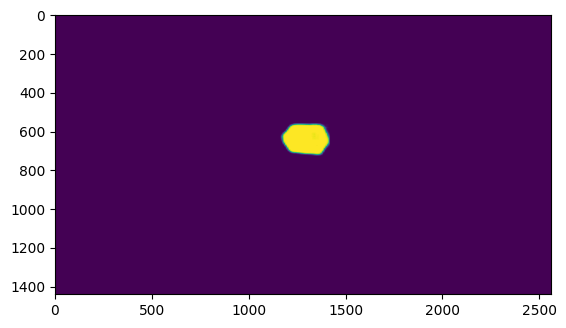

In [30]:
for i in range(10):
    img = Image.open('./data_Mask_RCNN/images/test/' + test_images[i])
    label = Image.open('./data_Mask_RCNN/labels/test/' + test_labels[i])
    transform = T.ToTensor()
    ig = transform(img)
    with torch.no_grad():
        pred = model([ig.to(device)])
    print('answer: ', np.unique(label))
    print('pred: ', pred[0]['labels'])
    plt.imshow((pred[0]["masks"][0].cpu().detach().numpy() * 255).astype("uint8").squeeze())

In [12]:
idx = 0
test_img = Image.open('./data_Mask_RCNN/images/test/' + test_images[idx]).convert('RGB')

In [13]:
transform = T.ToTensor()
ig = transform(test_img)
with torch.no_grad():
    pred = model([ig.to(device)])

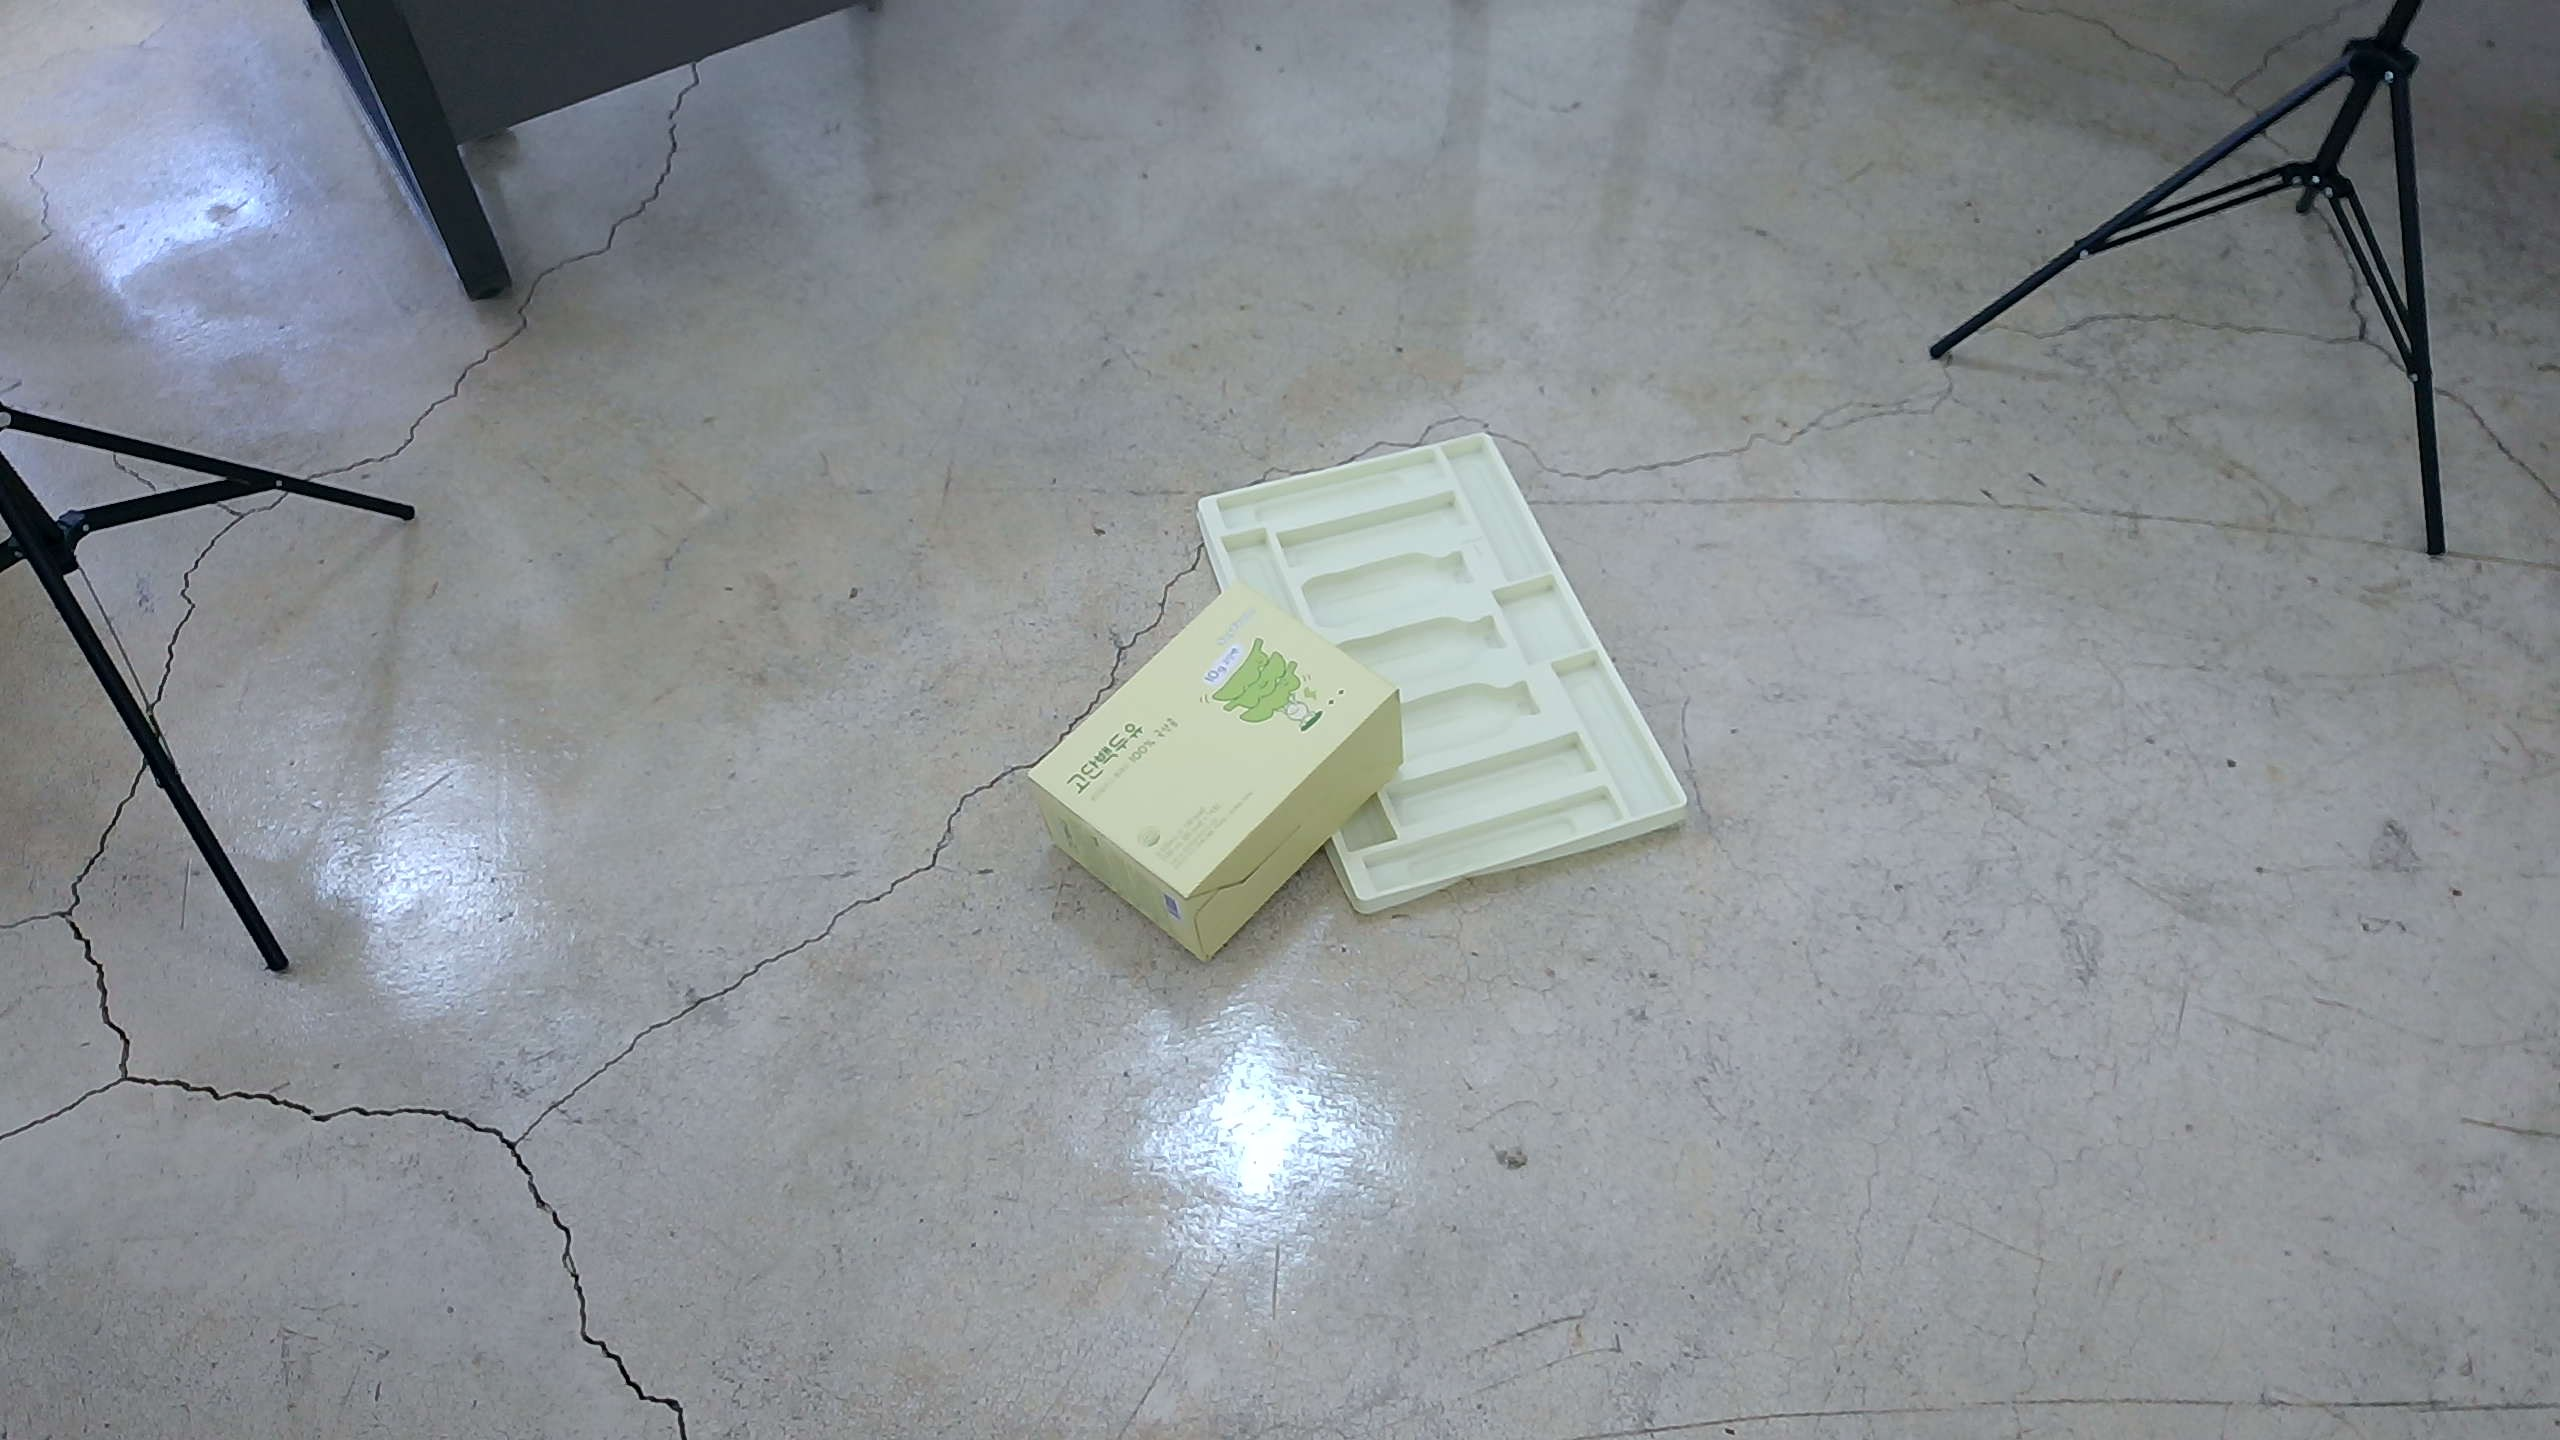

In [15]:
test_img

In [24]:
pred[0]

{'boxes': tensor([[1034.6978,  583.8630, 1405.6462,  968.9543],
         [1192.0485,  428.1681, 1675.3876,  917.1375],
         [   2.1881,  381.5768,  404.0127,  954.8582],
         [   0.0000,    6.3820,  444.9558,  419.2516],
         [1183.0951, 1076.1588, 1327.9680, 1199.9050],
         [1142.8982, 1032.5563, 1362.1375, 1206.8353]], device='cuda:0'),
 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'),
 'scores': tensor([1.0000, 0.9999, 0.3226, 0.2607, 0.1106, 0.0752], device='cuda:0'),
 'masks': tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
 
 
         [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],


In [23]:
pred[0]['labels']

tensor([1, 1, 1, 1, 1, 1], device='cuda:0')

In [25]:
pred[0]['boxes']

tensor([[1034.6978,  583.8630, 1405.6462,  968.9543],
        [1192.0485,  428.1681, 1675.3876,  917.1375],
        [   2.1881,  381.5768,  404.0127,  954.8582],
        [   0.0000,    6.3820,  444.9558,  419.2516],
        [1183.0951, 1076.1588, 1327.9680, 1199.9050],
        [1142.8982, 1032.5563, 1362.1375, 1206.8353]], device='cuda:0')

In [26]:
pred[0]['masks']

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..

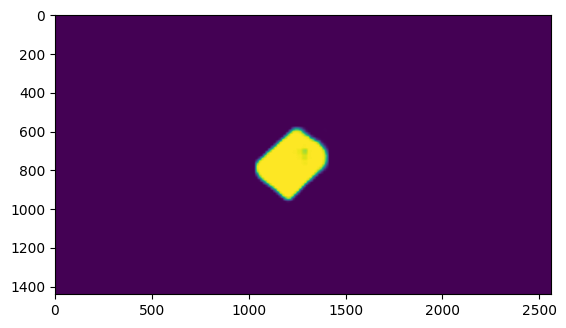

In [14]:
plt.imshow((pred[0]["masks"][0].cpu().detach().numpy() * 255).astype("uint8").squeeze())

In [27]:
test_mask = Image.open('./data_Mask_RCNN/labels/test/' + test_labels[idx])

In [28]:
np.unique(test_mask)

array([ 0,  1, 11], dtype=uint8)